<a href="https://colab.research.google.com/github/UCLM-LoUISE/TFG2022-LopezBermejo/blob/main/TFG_VGG_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inicialización

In [ ]:
!pip install tensorflow-gpu==2.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 497.9 MB 31 kB/s 
     |████████████████████████████████| 5.8 MB 70.9 MB/s 
     |████████████████████████████████| 1.4 MB 63.7 MB/s 
     |████████████████████████████████| 462 kB 76.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of th

In [ ]:
!pip install tensorflow-addons
!pip install keras-tuner -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.9 MB/s 
     |████████████████████████████████| 135 kB 15.5 MB/s 
     |████████████████████████████████| 1.6 MB 60.4 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow_addons as tfa
import keras_tuner
import keras.backend as K

# Para matriz de confusion
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd

# Para curvas ROC
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Para dataset
from sklearn.model_selection import train_test_split


import gc
import keras.backend as K

from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold			



In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

def predict_images(model):
  predictions = model.predict(imgs[:10])
  predictions = np.argmax(model.predict(imgs[:10]), axis=-1)
  label_predictions = []
  for prediction in predictions:
    label_predictions.append(class_names[prediction])
  print(label_predictions)
  plotImages(imgs[:10])

def print_metrics(history):
  # plt.figure(figsize=(30, 30))
  plt.rcParams['figure.figsize'] = [12, 7]
  history_frame = pd.DataFrame(history)
  history_frame.loc[:, ['f1_macro', 'val_f1_macro']].plot()
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.ylabel('F1', fontsize = 15)
  plt.xlabel('Epoch', fontsize = 15)
  plt.legend(['Validación', 'Entrenamiento'],loc='lower right' ,fontsize=15)
  plt.xticks(fontsize = 15)
  plt.yticks([0,0.2,0.4,0.6,0.8,1], fontsize = 15)
  plt.show()



def print_confusion(model, X_test, Y_test):
  y_true = np.array([int(np.where(y==1)[0]) for y in Y_test])
  y_pred = np.argmax(model.predict(X_test), axis=-1)


  con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                      index = class_names, 
                      columns = class_names)

  figure = plt.figure(figsize=(9, 9))
  res = sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues, annot_kws={"size": 15}, linewidths=0.3)
  res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 15)
  res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 15)
  plt.tight_layout()
  plt.ylabel('Clase real', fontsize = 15, color='green')
  plt.xlabel('Clase predicha', fontsize = 15, color='red')
  plt.show()


def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val




def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def recall_macro(y_true, y_pred):
     recall = 0
     pred = K.argmax(y_pred)
     true = K.argmax(y_true)
     for i in range(7):
         p = K.cast(K.equal(pred,i),'float32')
         t = K.cast(K.equal(true,i),'float32')
    #      # Compute the true positive
         common = K.sum(K.dot(K.reshape(t,(1,-1)),K.reshape(p,(-1,1))))
    #      # divide by all positives in t
        #  recall += common/(tf.constant(K.sum(t), dtype=tf.float32) + tf.constant(K.epsilon(), dtype=tf.float32))
         recall += float(common)/(float(K.sum(t)) + K.epsilon())
        #  recall = float(recall)
        #  recall += common/ (K.sum(t) + K.epsilon)
     return recall/7

def precision_macro(y_true, y_pred):
     precision = 0
     pred = K.argmax(y_pred)
     true = K.argmax(y_true)
     for i in range(7):
         p = K.cast(K.equal(pred,i),'float32')
         t = K.cast(K.equal(true,i),'float32')
    #      # Compute the true positive
         common = K.sum(K.dot(K.reshape(t,(1,-1)),K.reshape(p,(-1,1))))
    #      # divide by all positives in t
        #  recall += common/(tf.constant(K.sum(t), dtype=tf.float32) + tf.constant(K.epsilon(), dtype=tf.float32))
         precision += float(common)/(float(K.sum(p)) + K.epsilon())
        #  recall = float(recall)
        #  recall += common/ (K.sum(t) + K.epsilon)
     return precision/7

def f1_macro(y_true, y_pred):
     recall = 0
     precision = 0
     f1 = 0
     pred = K.argmax(y_pred) # Codificación integer [4,6,1,0]
     true = K.argmax(y_true) 
     for i in range(7):
         p = K.cast(K.equal(pred,i),'float32') # Vemos si el array de predicciones es igual a cada una de las clases
         t = K.cast(K.equal(true,i),'float32') # Vemos si el array true es igual a cada una de las clases
         # Compute the true positive
         common = K.sum(K.dot(K.reshape(t,(1,-1)),K.reshape(p,(-1,1)))) # TP

         recall = float(common)/(float(K.sum(t)) + K.epsilon()) # Sumamos Recall de la clase
         precision = float(common)/(float(K.sum(p)) + K.epsilon())
         f1 += 2*(precision*recall)/(precision+recall+K.epsilon())

     return f1/7

# function for scoring roc auc score for multi-class
def plot_multiclass_roc_auc_score(model, x, y, average="micro"):
    test_pred_raw = model.predict(x)
    y_pred = np.argmax(test_pred_raw, axis=1)
    y_test = np.argmax(y, axis=1)
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    print('ROC AUC score:', roc_auc_score(y_test, y_pred, average=average))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate', fontsize=15, color = 'red')
    c_ax.set_ylabel('True Positive Rate', fontsize=15, color = 'green')
    plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], fontsize=15)
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], fontsize=15)
    plt.rc('axes',  labelsize=15)
    plt.rc('legend', fontsize=15)
    plt.show()

class ClearRam(tf.keras.callbacks.Callback):
  def on_train_end(self, logs=None):
    gc.collect()

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  1


In [ ]:
if not(os.path.isdir('/content/train')):
  from google.colab import drive
  drive.mount('/content/drive')
  !cp '/content/drive/MyDrive/kaggle.json' .
  !pip install kaggle
  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download msambare/fer2013
  !unzip fer2013.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
 

In [ ]:
img_height = 48
img_width = 48

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
batch_size = 1

In [ ]:
ds_1 = tf.keras.utils.image_dataset_from_directory(
  '/content/train',
  color_mode = 'rgb',
  label_mode = 'int',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.


In [ ]:
ds_2 = tf.keras.utils.image_dataset_from_directory(
  '/content/test',
  color_mode = 'rgb',
  label_mode = 'int',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7178 files belonging to 7 classes.


In [ ]:
X_1 = []
X_2 = []
Y_1 = []
Y_2 = []


for imgs, labels in ds_1:
  for img in imgs:
    X_1.append(img)
  for label in labels:
    Y_1.append(label)

for imgs, labels in ds_2:
  for img in imgs:
    X_2.append(img)
  for label in labels:
    Y_2.append(label)
  
X_1 = np.array(X_1).astype(float)/255
X_2 = np.array(X_2).astype(float)/255

Y_1 = np.array(Y_1)
Y_2 = np.array(Y_2)



In [ ]:
X = np.concatenate((X_1, X_2), axis=0)

In [ ]:
Y = np.concatenate((Y_1, Y_2), axis=0)

In [ ]:
len(X)

35887

In [ ]:
len(Y)

35887

In [ ]:
train_ratio = 0.70
test_ratio = 0.20
validation_ratio = 0.10

In [ ]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=test_ratio)

X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=validation_ratio/(train_ratio+validation_ratio))


In [ ]:
Y_train = keras.utils.to_categorical(Y_train, dtype ="uint8", num_classes = 7)
Y_val = keras.utils.to_categorical(Y_val, dtype ="uint8", num_classes = 7)

In [ ]:
X_train_testing = X_train_val
X_test_testing = X_test
Y_train_testing = keras.utils.to_categorical(Y_train_val, dtype ="uint8", num_classes = 7)
Y_test_testing = keras.utils.to_categorical(Y_test, dtype ="uint8", num_classes = 7)

In [ ]:
print("Training: ", X_train.shape)
print("Validation: ", X_val.shape)
print("Test: ", X_test.shape)

Training:  (25120, 48, 48, 3)
Validation:  (3589, 48, 48, 3)
Test:  (7178, 48, 48, 3)


In [ ]:
class_names = ds_1.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
7


In [ ]:
class ClearRam(tf.keras.callbacks.Callback):
  def on_train_end(self, logs=None):
    gc.collect()

# VGG

In [ ]:
model = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=7,
    classifier_activation="softmax",
)

In [ ]:
model.summary()

#### Búsqueda bayesiana

* Versión: VGG16, VGG19
* Optimizer: Adam, SGD
* Learning_rate: 0.001, 0.0001, 0.00001
* Data augmentation: True, False

In [ ]:
# !rm -rf /content/drive/MyDrive/Tensorflow/VGG_optibayesian2/tb
# !rm -rf /content/drive/MyDrive/Tensorflow/VGG_optibayesian2/tb_logs

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=6, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor='val_f1_macro',
    mode="max"
)

In [ ]:
def VGG_version(version):

  if (version == 'VGG16'):
    base_model = keras.applications.VGG16(
              weights='imagenet',  # Pesos preentrenados de ImageNet.
              include_top=False,
              )
    return base_model

  if (version == 'VGG19'):
    base_model = keras.applications.VGG19(
                weights='imagenet',  # Pesos preentrenados de ImageNet.
                include_top=False)
    return base_model  
  

def VGG_optimizer(optimizer, learning_rate):

  if (optimizer=="Adam"):
    return keras.optimizers.Adam(learning_rate)
  if (optimizer=="SGD"):
    return keras.optimizers.SGD(learning_rate)


def RandomFlip():
  return tf.keras.layers.RandomFlip(mode="horizontal")

def RandomTranslation(factor):
  return tf.keras.layers.RandomTranslation(
                          height_factor = factor,
                          width_factor = factor,
                          fill_mode="constant",
                          interpolation="bilinear",
                          fill_value=0.0
                          )

def RandomZoom(factor):
  return tf.keras.layers.RandomZoom(
                          height_factor=factor,
                          width_factor=factor,
                          fill_mode="constant",
                          interpolation="bilinear",
                          fill_value=0.0
                          )
def RandomRotation(factor):
  return tf.keras.layers.RandomRotation(
                          factor = factor,
                          fill_mode="constant",
                          interpolation="bilinear",
                          fill_value=0.0
                          )


  
def DataAugmentation(factor):
  return Sequential([RandomFlip(),
                    RandomZoom(factor-0.10),
                    RandomTranslation(factor-0.18),
                    RandomRotation(factor-0.23)
                    ])
  

In [ ]:
class CustomBayesian(keras_tuner.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    # kwargs['callbacks'] = [early_stopping]
    kwargs['batch_size'] = trial.hyperparameters.Choice("batch_size", [32, 64, 128, 256])
    # if (trial.hyperparameters.Boolean("reduction")):
    #   kwargs['callbacks'] = [early_stopping, VGG_Reduce_LR(0.1), keras.callbacks.TensorBoard("/content/drive/MyDrive/Tensorflow/VGG_tuning/tb_logs")]
    # else:
    kwargs['callbacks'] = [early_stopping, keras.callbacks.TensorBoard("/content/drive/MyDrive/Tensorflow/VGG_optibayesian3/tb_logs")]
    return super(CustomBayesian, self).run_trial(trial, *args, **kwargs)

In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
    
      version = hp.Choice("version", ["VGG16", "VGG19"])
      optimizer = hp.Choice("optimizer", ["Adam", "SGD"])
      learning_rate = hp.Choice("learning_rate", [0.01, 0.001, 0.0001])
      augmentation = hp.Boolean("augmentation")

      base_model = VGG_version(version)
      model = keras.Sequential()
      model.add(tf.keras.Input(shape=(img_width, img_height, 3)))
      if (augmentation):
        model.add(DataAugmentation(0.25))
      model.add(base_model)
      model.add(layers.Flatten())
      model.add(layers.Dense(4096, activation='relu'))
      model.add(layers.Dense(4096, activation='relu'))
      model.add(layers.Dense(num_classes, activation="softmax"))

      # Compile the model.
      model.compile(
          optimizer=VGG_optimizer(optimizer, learning_rate),
          loss="categorical_crossentropy",
          metrics=['accuracy', tf.keras.metrics.AUC(name = "auc"), recall_macro, precision_macro, f1_macro],
      )
      return model

    def fit(self, hp, model, *args, **kwargs):
        
        return model.fit(
            *args,
            **kwargs,
        )


In [ ]:
tuner = CustomBayesian(
    hypermodel = MyHyperModel(),
    max_trials=30,
    executions_per_trial=1,
    # Do not resume the previous search in the same directory.
    overwrite=False,
    objective=keras_tuner.Objective("val_f1_macro", direction="max"),
    # Set a directory to store the intermediate results.
    directory="/content/drive/MyDrive/Tensorflow/VGG_optibayesian3/tb",
    project_name="VGG",
    beta=16
)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
version (Choice)
{'default': 'VGG16', 'conditions': [], 'values': ['VGG16', 'VGG19'], 'ordered': False}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'SGD'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
augmentation (Boolean)
{'default': False, 'conditions': []}
batch_size (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}


In [ ]:
tuner.search(
  X_train,
  Y_train,
  validation_data=(X_val, Y_val),
  epochs=500,
)

In [ ]:
tuner.results_summary(num_trials=20)

Results summary
Results in /content/drive/MyDrive/Tensorflow/VGG_optibayesian3/tb/VGG
Showing 20 best trials
Trial summary
Hyperparameters:
version: VGG16
optimizer: Adam
learning_rate: 0.0001
augmentation: False
batch_size: 256
Score: 0.6086000800132751
Trial summary
Hyperparameters:
version: VGG16
optimizer: Adam
learning_rate: 0.0001
augmentation: True
batch_size: 256
Score: 0.6006032228469849
Trial summary
Hyperparameters:
version: VGG19
optimizer: Adam
learning_rate: 0.0001
augmentation: True
batch_size: 256
Score: 0.5898964405059814
Trial summary
Hyperparameters:
version: VGG19
optimizer: Adam
learning_rate: 0.0001
augmentation: False
batch_size: 256
Score: 0.5892382860183716
Trial summary
Hyperparameters:
version: VGG19
optimizer: Adam
learning_rate: 0.0001
augmentation: True
batch_size: 256
Score: 0.5814560651779175
Trial summary
Hyperparameters:
version: VGG16
optimizer: Adam
learning_rate: 0.0001
augmentation: True
batch_size: 32
Score: 0.5652439594268799
Trial summary
Hyperp

## Mejor modelo 1

* VGG16
* Adam
* 0.0001
* False
* 256

In [ ]:
batch_size = 256
optimizer = keras.optimizers.Adam(1e-4)

In [ ]:
base_model = keras.applications.VGG16(
          weights='imagenet',  # Pesos preentrenados de ImageNet.
          include_top=False,
          )

In [ ]:
base_model.save_weights('/content/drive/MyDrive/Tensorflow/VGG_pesos_imagenet/')

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=5)[0]
model = tuner.hypermodel.build(best_hp)
model.summary()

In [ ]:
best_hp.values

#### Cross-validation

In [ ]:
# !rm -r '/content/drive/MyDrive/Tensorflow/VGG_averaged/tensorboard_logs'
# !rm -r '/content/drive/MyDrive/Tensorflow/VGG_averaged/VGG_checkpoints'

In [ ]:
def create_checkpoint(i):
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=f'/content/drive/MyDrive/Tensorflow/VGG_averaged/VGG_checkpoints/{i}',
    save_weights_only=True ,
    monitor='val_f1_macro',
    mode='max',
    save_best_only=True
  )

def create_tensorboard(i):
  return keras.callbacks.TensorBoard(f"/content/drive/MyDrive/Tensorflow/VGG_averaged/tensorboard_logs/{i}")

In [ ]:
# This code may not be run on GFG IDE
# as required packages are not found.
	
# STRATIFIES K-FOLD CROSS VALIDATION { 10-fold }

# Import Required Modules.
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold			


best_f1 = 0
metrics = []


for i in range(8):
	print(i)
	model.get_layer("vgg16").load_weights('/content/drive/MyDrive/Tensorflow/VGG_pesos_imagenet/')
	model.compile(
									optimizer=optimizer,
									loss=categorical_crossentropy,
									metrics=['accuracy', recall_macro, precision_macro, f1_macro]
								)
	history = model.fit(
		subsets[f'x_train_fold{i}'],
		subsets[f'y_train_fold{i}'],
		validation_data=(subsets[f'x_val_fold{i}'], subsets[f'y_val_fold{i}']),
		batch_size=batch_size,
		epochs=500,
		callbacks=[early_stopping, create_checkpoint(i), create_tensorboard(i)]
	)

	gc.collect()

	if (history.history["val_f1_macro"][-1] > best_f1):

		best_f1 = history.history["val_f1_macro"][-1]
		best_model = model
		best_model.save_weights('/content/drive/MyDrive/Tensorflow/VGG_averaged/best_model')
		best_model_id = i
		
	metrics.append(history)
	# model.save_weights(f'/content/drive/MyDrive/Tensorflow/VGG_averaged/VGG_weights/{i}')
	
 
print(best_model_id)

In [ ]:
acc_list = []
acc_avg = 0

f1_list = []
f1_avg = 0

precision_list = []
precision_avg = 0

recall_list = []
recall_avg = 0

for i in range(8):
  acc_list.append(metrics[i].history["val_accuracy"][-1])
  f1_list.append(metrics[i].history["val_f1_macro"][-1])
  precision_list.append(metrics[i].history["val_recall_macro"][-1])
  recall_list.append(metrics[i].history["val_precision_macro"][-1])

acc_avg = sum(acc_list)/8
f1_avg = sum(f1_list)/8
precision_avg = sum(precision_list)/8
recall_avg = sum(recall_list)/8

acc_stdev = stdev(acc_list)
f1_stdev = stdev(f1_list)
precision_stdev = stdev(precision_list)
recall_stdev = stdev(recall_list)

In [ ]:
print(acc_list)
print(precision_list)
print(recall_list)
print(f1_list)

In [ ]:
acc_list = [0.6478, 0.6512, 0.6088, 0.6252, 0.6266, 0.6237, 0.6452, 0.6480]
recall_list = [0.6016, 0.5916, 0.5620, 0.6196, 0.5903, 0.5780, 0.5973, 0.5969]
precision_list = [0.6151, 0.6335, 0.6004, 0.6331, 0.5950, 0.6421, 0.6448, 0.6405]
f1_list = [0.5982, 0.5977, 0.5644, 0.6173, 0.5863, 0.5894, 0.6075, 0.6062]

for i in range(8):
    print(i, round(acc_list[i], 4), round(precision_list[i], 4), round(recall_list[i], 4), round(f1_list[i], 4), sep=' & ', end='\\\ \n')
    print("\hline")
    print("")

In [ ]:
# acc_list = [0.6344385743141174, 0.6260796785354614, 0.6115909814834595, 0.6266369223594666, 0.6182780861854553, 0.6262542009353638, 0.6081382632255554, 0.6482720375061035]
acc_avg = sum(acc_list)/8

# f1_list = [0.5785022974014282, 0.5675160884857178, 0.5630576014518738, 0.6068615317344666, 0.5741955637931824, 0.5865286588668823, 0.5645330548286438, 0.5973895788192749]
f1_avg = sum(f1_list)/8

# precision_list = [0.5822791457176208, 0.564594030380249, 0.5660096406936646, 0.5994992852210999, 0.5659705996513367, 0.595296323299408, 0.5550307035446167, 0.6069095730781555]
precision_avg = sum(precision_list)/8

# recall_list = [0.6143820285797119, 0.6063836812973022, 0.590752363204956, 0.6374186873435974, 0.6083559393882751, 0.6304227709770203, 0.6163391470909119, 0.6046091914176941]
recall_avg = sum(recall_list)/8

acc_stdev = stdev(acc_list)
f1_stdev = stdev(f1_list)
precision_stdev = stdev(precision_list)
recall_stdev = stdev(recall_list)

In [ ]:
print("average acc: {}".format(acc_avg))
print("average f1: {}".format(f1_avg))
print("average precision: {}".format(precision_avg))
print("average recall: {}".format(recall_avg))
print("")
print("deviation acc: {}".format(acc_stdev))
print("deviation f1: {}".format(f1_stdev))
print("deviation precision: {}".format(precision_stdev))
print("deviation recall: {}".format(recall_stdev))

## Mejor modelo 2

* VGG16
* Adam
* 0.0001
* True
* 256

In [ ]:
batch_size = 256
optimizer = keras.optimizers.Adam(1e-4)

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=5)[1]
best_hp.values

In [ ]:
def get_model():
  best_hp = tuner.get_best_hyperparameters(num_trials=5)[1]
  model = tuner.hypermodel.build(best_hp)
  return model

#### Cross-validation

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=6, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor='val_f1_macro',
    mode="max"
)

In [ ]:
!rm -r '/content/drive/MyDrive/Tensorflow/VGG_averaged2/tensorboard_logs'
!rm -r '/content/drive/MyDrive/Tensorflow/VGG_averaged2/VGG_checkpoints'

In [ ]:
def create_checkpoint(i):
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=f'/content/drive/MyDrive/Tensorflow/VGG_averaged2/VGG_checkpoints/{i}',
    save_weights_only=True ,
    monitor='val_f1_macro',
    mode='max',
    save_best_only=True
  )

def create_tensorboard(i):
  return keras.callbacks.TensorBoard(f"/content/drive/MyDrive/Tensorflow/VGG_averaged2/tensorboard_logs/{i}")

In [ ]:
# This code may not be run on GFG IDE
# as required packages are not found.
	
# STRATIFIES K-FOLD CROSS VALIDATION { 10-fold }

# Import Required Modules.
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold			


best_f1 = 0
metrics = []
min_accuracy = 0

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=2)
lst_accu_stratified = []

for i, (train_index, test_index) in enumerate(skf.split(X_train_val, Y_train_val)):
	while(min_accuracy < 0.26):
		print(i)
		x_train_fold, x_val_fold = X_train_val[train_index], X_train_val[test_index]
		y_train_fold, y_val_fold = keras.utils.to_categorical(Y_train_val[train_index], dtype ="uint8", num_classes = 7), keras.utils.to_categorical(Y_train_val[test_index], dtype ="uint8", num_classes = 7)

		model = get_model()
		model.compile(
										optimizer=optimizer,
										loss=categorical_crossentropy,
										metrics=['accuracy', recall_macro, precision_macro, f1_macro]
									)
		history = model.fit(
			x_train_fold,
			y_train_fold,
			validation_data=(x_val_fold, y_val_fold),
			batch_size=batch_size,
			epochs=500,
			callbacks=[early_stopping, create_checkpoint(i), create_tensorboard(i)]
		)
	
		min_accuracy = history.history["val_accuracy"][-1]
		print(min_accuracy)
	
	min_accuracy = 0
	gc.collect()

	if (history.history["val_f1_macro"][-1] > best_f1):

		best_f1 = history.history["val_f1_macro"][-1]
		best_model = model
		best_model.save_weights('/content/drive/MyDrive/Tensorflow/VGG_averaged2/best_model')
		best_model_id = i
		
	metrics.append(history)
	# model.save_weights(f'/content/drive/MyDrive/Tensorflow/VGG_averaged/VGG_weights/{i}')
	
 
print(best_model_id)

In [ ]:
gc.collect()

In [ ]:
acc_list = []
acc_avg = 0

f1_list = []
f1_avg = 0

precision_list = []
precision_avg = 0

recall_list = []
recall_avg = 0

for i in range(8):
  acc_list.append(metrics[i].history["val_accuracy"][-1])
  f1_list.append(metrics[i].history["val_f1_macro"][-1])
  precision_list.append(metrics[i].history["val_recall_macro"][-1])
  recall_list.append(metrics[i].history["val_precision_macro"][-1])

acc_avg = sum(acc_list)/8
f1_avg = sum(f1_list)/8
precision_avg = sum(precision_list)/8
recall_avg = sum(recall_list)/8

acc_stdev = stdev(acc_list)
f1_stdev = stdev(f1_list)
precision_stdev = stdev(precision_list)
recall_stdev = stdev(recall_list)

In [ ]:
print(acc_list)
print(precision_list)
print(recall_list)
print(f1_list)

In [ ]:
acc_list = [0.5865, 0.6041, 0.5977, 0.5762, 0.6030, 0.5914, 0.6009,0.5889]
recall_list = [0.5701, 0.5795, 0.5579, 0.5462, 0.5683, 0.5475, 0.5711, 0.5564]
precision_list = [0.6015, 0.6024, 0.5921, 0.5687, 0.5480, 0.5604, 0.5894, 0.5948 ]
f1_list = [0.5718, 0.5776, 0.5632, 0.5480, 0.5481, 0.5456, 0.5724, 0.5622]

for i in range(8):
    print(i, round(acc_list[i], 4), round(precision_list[i], 4), round(recall_list[i], 4), round(f1_list[i], 4), sep=' & ', end='\\\ \n')
    print("\hline")
    print("")

In [ ]:
# acc_list = [0.6344385743141174, 0.6260796785354614, 0.6115909814834595, 0.6266369223594666, 0.6182780861854553, 0.6262542009353638, 0.6081382632255554, 0.6482720375061035]
acc_avg = sum(acc_list)/8

# f1_list = [0.5785022974014282, 0.5675160884857178, 0.5630576014518738, 0.6068615317344666, 0.5741955637931824, 0.5865286588668823, 0.5645330548286438, 0.5973895788192749]
f1_avg = sum(f1_list)/8

# precision_list = [0.5822791457176208, 0.564594030380249, 0.5660096406936646, 0.5994992852210999, 0.5659705996513367, 0.595296323299408, 0.5550307035446167, 0.6069095730781555]
precision_avg = sum(precision_list)/8

# recall_list = [0.6143820285797119, 0.6063836812973022, 0.590752363204956, 0.6374186873435974, 0.6083559393882751, 0.6304227709770203, 0.6163391470909119, 0.6046091914176941]
recall_avg = sum(recall_list)/8

acc_stdev = stdev(acc_list)
f1_stdev = stdev(f1_list)
precision_stdev = stdev(precision_list)
recall_stdev = stdev(recall_list)

In [ ]:
print("average acc: {}".format(acc_avg))
print("average f1: {}".format(f1_avg))
print("average precision: {}".format(precision_avg))
print("average recall: {}".format(recall_avg))
print("")
print("deviation acc: {}".format(acc_stdev))
print("deviation f1: {}".format(f1_stdev))
print("deviation precision: {}".format(precision_stdev))
print("deviation recall: {}".format(recall_stdev))

## Mejor modelo 3

* VGG19
* Adam
* 0.0001
* True
* 256

In [ ]:
batch_size = 256
optimizer = keras.optimizers.Adam(1e-4)

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=5)[2]
best_hp.values

In [ ]:
def get_model():
  best_hp = tuner.get_best_hyperparameters(num_trials=5)[2]
  model = tuner.hypermodel.build(best_hp)
  return model

#### Cross-validation

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=6, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor='val_f1_macro',
    mode="max"
)

In [ ]:
!rm -r '/content/drive/MyDrive/Tensorflow/VGG_averaged3/tensorboard_logs'
!rm -r '/content/drive/MyDrive/Tensorflow/VGG_averaged3/VGG_checkpoints'

In [ ]:
def create_checkpoint(i):
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=f'/content/drive/MyDrive/Tensorflow/VGG_averaged3/VGG_checkpoints/{i}',
    save_weights_only=True ,
    monitor='val_f1_macro',
    mode='max',
    save_best_only=True
  )

def create_tensorboard(i):
  return keras.callbacks.TensorBoard(f"/content/drive/MyDrive/Tensorflow/VGG_averaged3/tensorboard_logs/{i}")

In [ ]:
# This code may not be run on GFG IDE
# as required packages are not found.
	
# STRATIFIES K-FOLD CROSS VALIDATION { 10-fold }

# Import Required Modules.
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold			


best_f1 = 0
metrics = []
min_accuracy = 0

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=2)
lst_accu_stratified = []

for i, (train_index, test_index) in enumerate(skf.split(X_train_val, Y_train_val)):
	while(min_accuracy < 0.26):
		print(i)
		x_train_fold, x_val_fold = X_train_val[train_index], X_train_val[test_index]
		y_train_fold, y_val_fold = keras.utils.to_categorical(Y_train_val[train_index], dtype ="uint8", num_classes = 7), keras.utils.to_categorical(Y_train_val[test_index], dtype ="uint8", num_classes = 7)

		model = get_model()
		model.compile(
										optimizer=optimizer,
										loss=categorical_crossentropy,
										metrics=['accuracy', recall_macro, precision_macro, f1_macro]
									)
		history = model.fit(
			x_train_fold,
			y_train_fold,
			validation_data=(x_val_fold, y_val_fold),
			batch_size=batch_size,
			epochs=500,
			callbacks=[early_stopping, create_checkpoint(i), create_tensorboard(i)]
		)
	
		min_accuracy = history.history["val_accuracy"][-1]
		print(min_accuracy)
	
	min_accuracy = 0
	gc.collect()

	if (history.history["val_f1_macro"][-1] > best_f1):

		best_f1 = history.history["val_f1_macro"][-1]
		best_model = model
		best_model.save_weights('/content/drive/MyDrive/Tensorflow/VGG_averaged3/best_model')
		best_model_id = i
		
	metrics.append(history)
	
 
print(best_model_id)

In [ ]:
acc_list = []
acc_avg = 0

f1_list = []
f1_avg = 0

precision_list = []
precision_avg = 0

recall_list = []
recall_avg = 0

for i in range(8):
  acc_list.append(metrics[i].history["val_accuracy"][-1])
  f1_list.append(metrics[i].history["val_f1_macro"][-1])
  precision_list.append(metrics[i].history["val_recall_macro"][-1])
  recall_list.append(metrics[i].history["val_precision_macro"][-1])

print(acc_list)
acc_avg = sum(acc_list)/8
print(acc_avg)
f1_avg = sum(f1_list)/8
print(acc_list)
precision_avg = sum(precision_list)/8
recall_avg = sum(recall_list)/8
print(f1_list)

acc_stdev = stdev(acc_list)
f1_stdev = stdev(f1_list)
precision_stdev = stdev(precision_list)
recall_stdev = stdev(recall_list)

In [ ]:
print(acc_list)
print(precision_list)
print(recall_list)
print(f1_list)

In [ ]:
acc_list = [0.5946, 0.5831, 0.6110, 0.5782, 0.6091, 0.5981, 0.6115, 0.6073]
recall_list = [0.5777, 0.5831,0.5635, 0.5237, 0.5570, 0.5667, 0.5524, 0.5662]
precision_list = [0.6147, 0.5917, 0.5958, 0.5647, 0.5830, 0.5967, 0.5937, 0.5859]
f1_list = [0.5859, 0.5757, 0.5710, 0.5273, 0.5609, 0.5696, 0.5606, 0.5680]

for i in range(8):
    print(i, round(acc_list[i], 4), round(precision_list[i], 4), round(recall_list[i], 4), round(f1_list[i], 4), sep=' & ', end='\\\ \n')
    print("\hline")
    print("")

In [ ]:
# acc_list = [0.6344385743141174, 0.6260796785354614, 0.6115909814834595, 0.6266369223594666, 0.6182780861854553, 0.6262542009353638, 0.6081382632255554, 0.6482720375061035]
acc_avg = sum(acc_list)/8

# f1_list = [0.5785022974014282, 0.5675160884857178, 0.5630576014518738, 0.6068615317344666, 0.5741955637931824, 0.5865286588668823, 0.5645330548286438, 0.5973895788192749]
f1_avg = sum(f1_list)/8

# precision_list = [0.5822791457176208, 0.564594030380249, 0.5660096406936646, 0.5994992852210999, 0.5659705996513367, 0.595296323299408, 0.5550307035446167, 0.6069095730781555]
precision_avg = sum(precision_list)/8

# recall_list = [0.6143820285797119, 0.6063836812973022, 0.590752363204956, 0.6374186873435974, 0.6083559393882751, 0.6304227709770203, 0.6163391470909119, 0.6046091914176941]
recall_avg = sum(recall_list)/8

acc_stdev = stdev(acc_list)
f1_stdev = stdev(f1_list)
precision_stdev = stdev(precision_list)
recall_stdev = stdev(recall_list)

In [ ]:
print("average acc: {}".format(acc_avg))
print("average f1: {}".format(f1_avg))
print("average precision: {}".format(precision_avg))
print("average recall: {}".format(recall_avg))
print("")
print("deviation acc: {}".format(acc_stdev))
print("deviation f1: {}".format(f1_stdev))
print("deviation precision: {}".format(precision_stdev))
print("deviation recall: {}".format(recall_stdev))

## Modelo final

In [ ]:
batch_size = 256
optimizer = keras.optimizers.Adam(1e-4)

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp.values

{'version': 'VGG16',
 'optimizer': 'Adam',
 'learning_rate': 0.0001,
 'augmentation': False,
 'batch_size': 256}

In [ ]:
def get_model():
  best_hp = tuner.get_best_hyperparameters(num_trials=5)[0]
  model = tuner.hypermodel.build(best_hp)
  return model

### Mejor modelo

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=6, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor='val_f1_macro',
    mode="max"
)

In [ ]:
def create_checkpoint():
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=f'/content/drive/MyDrive/Tensorflow/VGG_final/VGG_checkpoints',
    save_weights_only=True ,
    monitor='val_f1_macro',
    mode='max',
    save_best_only=True
  )

def create_tensorboard():
  return keras.callbacks.TensorBoard(f"/content/drive/MyDrive/Tensorflow/VGG_final/tensorboard_logs")

In [ ]:
model = get_model()
model.compile(
                optimizer=optimizer,
                loss=categorical_crossentropy,
                metrics=['accuracy', recall_macro, precision_macro, f1_macro]
              )
history = model.fit(
  X_train_testing,
  Y_train_testing,
  validation_data=(X_test_testing, Y_test_testing),
  batch_size=batch_size,
  epochs=500,
  callbacks=[early_stopping, create_checkpoint(), create_tensorboard()]
)

#### Métricas

In [ ]:
model.evaluate(X_test_testing, Y_test_testing)

In [ ]:
plot_multiclass_roc_auc_score(model, X_test_testing, Y_test_testing)

In [ ]:
print_confusion(model, X_test_testing, Y_test_testing)

### Iteraciones

In [ ]:
!rm -r '/content/drive/MyDrive/Tensorflow/VGG_test/tensorboard_logs'
!rm -r '/content/drive/MyDrive/Tensorflow/VGG_test/VGG_checkpoints'

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=6, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor='val_f1_macro',
    mode="max"
)

In [ ]:
def create_checkpoint(i):
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=f'/content/drive/MyDrive/Tensorflow/VGG_test/VGG_checkpoints/{i}',
    save_weights_only=True ,
    monitor='val_f1_macro',
    mode='max',
    save_best_only=True
  )

def create_tensorboard(i):
  return keras.callbacks.TensorBoard(f"/content/drive/MyDrive/Tensorflow/VGG_test/tensorboard_logs/{i}")

In [ ]:
# This code may not be run on GFG IDE
# as required packages are not found.
	
# STRATIFIES K-FOLD CROSS VALIDATION { 10-fold }

# Import Required Modules.
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold			


best_f1 = 0
metrics = []
min_accuracy = 0


for i in range(10):
	X_train_val, X_test, Y_train_val_aux, Y_test_aux = train_test_split(X, Y, test_size=test_ratio, shuffle=True, random_state=i)
	Y_train_val = keras.utils.to_categorical(Y_train_val_aux, dtype ="uint8", num_classes = 7)
	Y_test = keras.utils.to_categorical(Y_test_aux, dtype ="uint8", num_classes = 7)
 
	while(min_accuracy < 0.26):
		print(i)
	
		model = get_model()
		model.compile(
										optimizer=optimizer,
										loss=categorical_crossentropy,
										metrics=['accuracy', recall_macro, precision_macro, f1_macro]
									)
		history = model.fit(
			X_train_val,
			Y_train_val,
			validation_data=(X_test, Y_test),
			batch_size=batch_size,
			epochs=500,
			callbacks=[early_stopping, create_checkpoint(i), create_tensorboard(i)]
		)

		min_accuracy = history.history["val_accuracy"][-1]
		print(min_accuracy)
	
	min_accuracy = 0
	gc.collect()


	if (history.history["val_f1_macro"][-1] > best_f1):

		best_f1 = history.history["val_f1_macro"][-1]
		best_model = model
		best_model.save_weights('/content/drive/MyDrive/Tensorflow/VGG_test/best_model')
		best_model_id = i
		best_model
		
	metrics.append(history)
	model.save_weights(f'/content/drive/MyDrive/Tensorflow/VGG_test/VGG_weights/{i}')
 
print(i)

In [ ]:
acc_list = []
acc_avg = 0

f1_list = []
f1_avg = 0

precision_list = []
precision_avg = 0

recall_list = []
recall_avg = 0

for i in range(10):
  acc_list.append(metrics[i].history["val_accuracy"][-7])
  f1_list.append(metrics[i].history["val_f1_macro"][-7])
  precision_list.append(metrics[i].history["val_recall_macro"][-7])
  recall_list.append(metrics[i].history["val_precision_macro"][-7])

acc_avg = sum(acc_list)/10
f1_avg = sum(f1_list)/10
precision_avg = sum(precision_list)/10
recall_avg = sum(recall_list)/10

acc_stdev = stdev(acc_list)
f1_stdev = stdev(f1_list)
precision_stdev = stdev(precision_list)
recall_stdev = stdev(recall_list)

In [ ]:
print(acc_list)
print(precision_list)
print(recall_list)
print(f1_list)

In [ ]:
for i in range(10):
    print(i, round(acc_list[i], 4), round(precision_list[i], 4), round(recall_list[i], 4), round(f1_list[i], 4), sep=' & ', end='\\\ \n')
    print("\hline")
    print("")

In [ ]:
print("average acc: {}".format(acc_avg))
print("average precision: {}".format(precision_avg))
print("average recall: {}".format(recall_avg))
print("average f1: {}".format(f1_avg))
print("")
print("deviation acc: {}".format(acc_stdev))
print("deviation precision: {}".format(precision_stdev))
print("deviation recall: {}".format(recall_stdev))
print("deviation f1: {}".format(f1_stdev))

### Iteraciones métricas

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=6, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor='val_f1_macro',
    mode="max"
)

In [ ]:
# This code may not be run on GFG IDE
# as required packages are not found.
	
# STRATIFIES K-FOLD CROSS VALIDATION { 10-fold }

# Import Required Modules.
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold			


best_f1 = 0
metrics = []
min_accuracy = 0

i=0

X_train_val, X_test, Y_train_val_aux, Y_test_aux = train_test_split(X, Y, test_size=test_ratio, shuffle=True, random_state=i)
Y_train_val = keras.utils.to_categorical(Y_train_val_aux, dtype ="uint8", num_classes = 7)
Y_test = keras.utils.to_categorical(Y_test_aux, dtype ="uint8", num_classes = 7)

print(i)

model = get_model()
model.compile(
								optimizer=optimizer,
								loss=categorical_crossentropy,
								metrics=['accuracy', recall_macro, precision_macro, f1_macro]
							)
history = model.fit(
	X_train_val,
	Y_train_val,
	validation_data=(X_test, Y_test),
	batch_size=batch_size,
	epochs=500,
	callbacks=[early_stopping]
)

min_accuracy = history.history["val_accuracy"][-1]
print(min_accuracy)

min_accuracy = 0
gc.collect()


#### Métricas

In [ ]:
model.evaluate(X_test, Y_test)

In [ ]:
plot_multiclass_roc_auc_score(model, X_test, Y_test)

In [ ]:
print_confusion(model, X_test, Y_test)

In [ ]:
print(history.history)

In [ ]:
history = {'loss': [1.347541093826294, 0.9306772947311401, 0.6428182125091553, 0.37469762563705444, 0.19501473009586334, 0.09422457963228226, 0.06671749800443649, 0.05595909804105759, 0.04507317766547203, 0.045458897948265076, 0.04590902850031853, 0.041430242359638214, 0.05552909895777702], 'accuracy': [0.4938521087169647, 0.6562750339508057, 0.766972005367279, 0.8707722425460815, 0.9377198815345764, 0.9732836484909058, 0.9810512661933899, 0.9841164946556091, 0.9872514009475708, 0.9867985844612122, 0.9854401350021362, 0.9865895509719849, 0.9825838804244995], 'recall_macro': [0.41425126791000366, 0.6051335334777832, 0.7389987111091614, 0.855598509311676, 0.9298837780952454, 0.9681864380836487, 0.9796259999275208, 0.9785261154174805, 0.9826949238777161, 0.9807159900665283, 0.9811998009681702, 0.9811928868293762, 0.9794124960899353], 'precision_macro': [0.43011724948883057, 0.6432750225067139, 0.7706432938575745, 0.8648855686187744, 0.9355819821357727, 0.9704926013946533, 0.980277955532074, 0.9783247709274292, 0.9815828204154968, 0.9785203337669373, 0.9805794358253479, 0.9810041189193726, 0.977142333984375], 'f1_macro': [0.4062369763851166, 0.6073983311653137, 0.7448527216911316, 0.8553099036216736, 0.9304772615432739, 0.9683173298835754, 0.979252278804779, 0.9779497385025024, 0.9816099405288696, 0.9791091084480286, 0.9802684187889099, 0.9806612133979797, 0.9776449203491211], 'val_loss': [1.7871588468551636, 1.1424386501312256, 1.1431187391281128, 1.2224243879318237, 1.470974087715149, 1.5877749919891357, 1.6753466129302979, 1.8227349519729614, 1.8071826696395874, 1.8639411926269531, 1.926903486251831, 1.9509762525558472, 2.066281318664551], 'val_accuracy': [0.47366955876350403, 0.5752298831939697, 0.5826135277748108, 0.6016996502876282, 0.6097798943519592, 0.638617992401123, 0.6370855569839478, 0.61451655626297, 0.6369462013244629, 0.6362496614456177, 0.6337419748306274, 0.6323488354682922, 0.6161883473396301], 'val_recall_macro': [0.3810148537158966, 0.4985922574996948, 0.5002400875091553, 0.5495229959487915, 0.5585622191429138, 0.5895546078681946, 0.593383252620697, 0.5807342529296875, 0.5925350189208984, 0.5872601270675659, 0.5956063866615295, 0.5974231958389282, 0.5815554261207581], 'val_precision_macro': [0.43995431065559387, 0.5437009334564209, 0.5856515765190125, 0.5932974815368652, 0.5885465741157532, 0.6220329403877258, 0.6261200308799744, 0.6263560056686401, 0.619488000869751, 0.6180701851844788, 0.6205849647521973, 0.6113878488540649, 0.5934773087501526], 'val_f1_macro': [0.3447808623313904, 0.501211404800415, 0.5163967609405518, 0.558059811592102, 0.5635287761688232, 0.5949987769126892, 0.5994217991828918, 0.5912859439849854, 0.5963476896286011, 0.5955535173416138, 0.599404513835907, 0.5991510152816772, 0.578220784664154]}

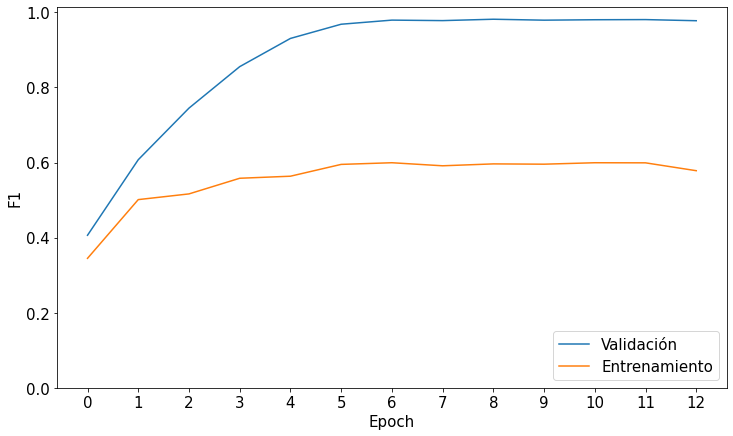

In [ ]:
print_metrics(history)

## Modelo final resized

In [ ]:
batch_size = 256
optimizer = keras.optimizers.Adam(1e-4)

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp.values

In [ ]:
def get_model():
  model = Keras.Sequential([
      layers.experimental.preprocessing.Resizing(75, 75, interpolation="bilinear", input_shape=(img_height, img_width, 3))

  ])
  best_hp = tuner.get_best_hyperparameters(num_trials=5)[0]
  model = tuner.hypermodel.build(best_hp)
  return model

### Mejor modelo

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=6, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor='val_f1_macro',
    mode="max"
)

In [ ]:
def create_checkpoint():
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=f'/content/drive/MyDrive/Tensorflow/VGG_final/VGG_checkpoints',
    save_weights_only=True ,
    monitor='val_f1_macro',
    mode='max',
    save_best_only=True
  )

def create_tensorboard():
  return keras.callbacks.TensorBoard(f"/content/drive/MyDrive/Tensorflow/VGG_final/tensorboard_logs")

In [ ]:
model = get_model()
model.compile(
                optimizer=optimizer,
                loss=categorical_crossentropy,
                metrics=['accuracy', recall_macro, precision_macro, f1_macro]
              )
history = model.fit(
  X_train_testing,
  Y_train_testing,
  validation_data=(X_test_testing, Y_test_testing),
  batch_size=batch_size,
  epochs=500,
  callbacks=[early_stopping, create_checkpoint(), create_tensorboard()]
)

### Iteraciones resized

In [ ]:
!rm -r '/content/drive/MyDrive/Tensorflow/VGG_test_resized/tensorboard_logs'
!rm -r '/content/drive/MyDrive/Tensorflow/VGG_test_resized/VGG_checkpoints'

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=6, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor='val_f1_macro',
    mode="max"
)

In [ ]:
def create_checkpoint(i):
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=f'/content/drive/MyDrive/Tensorflow/VGG_test_resized/VGG_checkpoints/{i}',
    save_weights_only=True ,
    monitor='val_f1_macro',
    mode='max',
    save_best_only=True
  )

def create_tensorboard(i):
  return keras.callbacks.TensorBoard(f"/content/drive/MyDrive/Tensorflow/VGG_test_resized/tensorboard_logs/{i}")

In [ ]:
# This code may not be run on GFG IDE
# as required packages are not found.
	
# STRATIFIES K-FOLD CROSS VALIDATION { 10-fold }

# Import Required Modules.
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold			


best_f1 = 0
metrics = []
min_accuracy = 0


for i in range(10):
	X_train_val, X_test, Y_train_val_aux, Y_test_aux = train_test_split(X, Y, test_size=test_ratio, shuffle=True, random_state=i)
	Y_train_val = keras.utils.to_categorical(Y_train_val_aux, dtype ="uint8", num_classes = 7)
	Y_test = keras.utils.to_categorical(Y_test_aux, dtype ="uint8", num_classes = 7)
 
	while(min_accuracy < 0.26):
		print(i)
	
		model = get_model()
		model.compile(
										optimizer=optimizer,
										loss=categorical_crossentropy,
										metrics=['accuracy', recall_macro, precision_macro, f1_macro]
									)
		history = model.fit(
			X_train_val,
			Y_train_val,
			validation_data=(X_test, Y_test),
			batch_size=batch_size,
			epochs=500,
			callbacks=[early_stopping, create_checkpoint(i), create_tensorboard(i)]
		)

		min_accuracy = history.history["val_accuracy"][-1]
		print(min_accuracy)
	
	min_accuracy = 0
	gc.collect()


	if (history.history["val_f1_macro"][-1] > best_f1):

		best_f1 = history.history["val_f1_macro"][-1]
		best_model = model
		best_model.save_weights('/content/drive/MyDrive/Tensorflow/VGG_test_resized/best_model')
		best_model_id = i
		best_model
		
	metrics.append(history)
	model.save_weights(f'/content/drive/MyDrive/Tensorflow/VGG_test_resized/VGG_weights/{i}')
 
print(i)

In [ ]:
acc_list = []
acc_avg = 0

f1_list = []
f1_avg = 0

precision_list = []
precision_avg = 0

recall_list = []
recall_avg = 0

for i in range(10):
  acc_list.append(metrics[i].history["val_accuracy"][-1])
  f1_list.append(metrics[i].history["val_f1_macro"][-1])
  precision_list.append(metrics[i].history["val_recall_macro"][-1])
  recall_list.append(metrics[i].history["val_precision_macro"][-1])

acc_avg = sum(acc_list)/10
f1_avg = sum(f1_list)/10
precision_avg = sum(precision_list)/10
recall_avg = sum(recall_list)/10

acc_stdev = stdev(acc_list)
f1_stdev = stdev(f1_list)
precision_stdev = stdev(precision_list)
recall_stdev = stdev(recall_list)

In [ ]:
print(acc_list)
print(precision_list)
print(recall_list)
print(f1_list)

In [ ]:
for i in range(10):
    print(i, round(acc_list[i], 4), round(precision_list[i], 4), round(recall_list[i], 4), round(f1_list[i], 4), sep=' & ', end='\\\ \n')
    print("\hline")
    print("")

In [ ]:
print("average acc: {}".format(acc_avg))
print("average precision: {}".format(precision_avg))
print("average recall: {}".format(recall_avg))
print("average f1: {}".format(f1_avg))
print("")
print("deviation acc: {}".format(acc_stdev))
print("deviation precision: {}".format(precision_stdev))
print("deviation recall: {}".format(recall_stdev))
print("deviation f1: {}".format(f1_stdev))

# ResNet50

In [ ]:
model = tf.keras.applications.ResNet50V2(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
)

In [ ]:
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

#### Búsqueda bayesiana

* Versión: ResNet50V2, ResNet101V2, ResNet152V2
* Optimizer: Adam, SGD
* Learning_rate: 0.001, 0.0001, 0.00001
* Data augmentation: True, False

In [ ]:
# !rm -rf /content/drive/MyDrive/Tensorflow/ResNet_tuning_bayesian/tb
# !rm -rf /content/drive/MyDrive/Tensorflow/ResNet_tuning_bayesian/tb_logs

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=6, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor='val_f1_macro',
    mode="max"
)

In [ ]:
def ResNet_version(version):

  if (version == 'ResNet50V2'):
    base_model = keras.applications.ResNet50V2(
              weights='imagenet',  # Pesos preentrenados de ImageNet.
              include_top=False,
              )
    return base_model

  if (version == 'ResNet101V2'):
    base_model = keras.applications.ResNet101V2(
                weights='imagenet',  # Pesos preentrenados de ImageNet.
                include_top=False)
    return base_model

  if (version == 'ResNet152V2'):
    base_model = keras.applications.ResNet152V2(
                weights='imagenet',  # Pesos preentrenados de ImageNet.
                include_top=False)
    return base_model 
  

def opti(optimizer, learning_rate):

  if (optimizer=="Adam"):
    return keras.optimizers.Adam(learning_rate)
  if (optimizer=="SGD"):
    return keras.optimizers.SGD(learning_rate)


def RandomFlip():
  return tf.keras.layers.RandomFlip(mode="horizontal")

def RandomTranslation(factor):
  return tf.keras.layers.RandomTranslation(
                          height_factor = factor,
                          width_factor = factor,
                          fill_mode="constant",
                          interpolation="bilinear",
                          fill_value=0.0
                          )

def RandomZoom(factor):
  return tf.keras.layers.RandomZoom(
                          height_factor=factor,
                          width_factor=factor,
                          fill_mode="constant",
                          interpolation="bilinear",
                          fill_value=0.0
                          )
def RandomRotation(factor):
  return tf.keras.layers.RandomRotation(
                          factor = factor,
                          fill_mode="constant",
                          interpolation="bilinear",
                          fill_value=0.0
                          )


  
def DataAugmentation(factor):
  return Sequential([RandomFlip(),
                    RandomZoom(factor-0.10),
                    RandomTranslation(factor-0.18),
                    RandomRotation(factor-0.23)
                    ])
  

In [ ]:
class CustomBayesian(keras_tuner.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Choice("batch_size", [32, 64, 128, 256])
    kwargs['callbacks'] = [early_stopping, keras.callbacks.TensorBoard("/content/drive/MyDrive/Tensorflow/ResNet_tuning_bayesian/tb_logs")]
    return super(CustomBayesian, self).run_trial(trial, *args, **kwargs)

In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
    
      version = hp.Choice("version", ['ResNet50V2', 'ResNet101V2', 'ResNet152V2'])
      optimizer = hp.Choice("optimizer", ["Adam", "SGD"])
      learning_rate = hp.Choice("learning_rate", [0.01, 0.001, 0.0001])
      augmentation = hp.Boolean("augmentation")

      base_model = ResNet_version(version)
      model = keras.Sequential()
      model.add(tf.keras.Input(shape=(img_width, img_height, 3)))
      if (augmentation):
        model.add(DataAugmentation(0.25))
      model.add(base_model)
      model.add(layers.GlobalAveragePooling2D())
      model.add(layers.Dense(num_classes, activation="softmax"))

      # Compile the model.
      model.compile(
          optimizer=opti(optimizer, learning_rate),
          loss="categorical_crossentropy",
          metrics=['accuracy', tf.keras.metrics.AUC(name = "auc"), recall_macro, precision_macro, f1_macro, specificity],
      )
      return model

    def fit(self, hp, model, *args, **kwargs):
        
        return model.fit(
            *args,
            **kwargs,
        )


In [ ]:
tuner = CustomBayesian(
    hypermodel = MyHyperModel(),
    max_trials=30,
    executions_per_trial=1,
    # Do not resume the previous search in the same directory.
    overwrite=False,
    objective=keras_tuner.Objective("val_f1_macro", direction="max"),
    # Set a directory to store the intermediate results.
    directory="/content/drive/MyDrive/Tensorflow/ResNet_tuning_bayesian/tb",
    project_name="ResNet",
    beta=16
)

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
version (Choice)
{'default': 'ResNet50V2', 'conditions': [], 'values': ['ResNet50V2', 'ResNet101V2', 'ResNet152V2'], 'ordered': False}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'SGD'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
augmentation (Boolean)
{'default': False, 'conditions': []}
batch_size (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}


In [ ]:
tuner.search(
  X_train,
  Y_train,
  validation_data=(X_val, Y_val),
  epochs=500,
)

In [ ]:
tuner.results_summary(num_trials=20)

Results summary
Results in /content/drive/MyDrive/Tensorflow/ResNet_tuning_bayesian/tb/ResNet
Showing 20 best trials
Trial summary
Hyperparameters:
version: ResNet152V2
optimizer: Adam
learning_rate: 0.0001
augmentation: True
batch_size: 256
Score: 0.5415641665458679
Trial summary
Hyperparameters:
version: ResNet152V2
optimizer: Adam
learning_rate: 0.0001
augmentation: False
batch_size: 256
Score: 0.5408679246902466
Trial summary
Hyperparameters:
version: ResNet50V2
optimizer: Adam
learning_rate: 0.0001
augmentation: True
batch_size: 256
Score: 0.5391217470169067
Trial summary
Hyperparameters:
version: ResNet50V2
optimizer: SGD
learning_rate: 0.01
augmentation: True
batch_size: 256
Score: 0.5190572142601013
Trial summary
Hyperparameters:
version: ResNet50V2
optimizer: Adam
learning_rate: 0.0001
augmentation: False
batch_size: 256
Score: 0.5162788033485413
Trial summary
Hyperparameters:
version: ResNet50V2
optimizer: Adam
learning_rate: 0.0001
augmentation: True
batch_size: 32
Score: 0.

## Mejor modelo 1

* ResNet152V2
* Adam
* 0.0001
* True
* 256

In [ ]:
batch_size = 256
optimizer = keras.optimizers.Adam(1e-4)

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=5)[0]
best_hp.values

{'version': 'ResNet152V2',
 'optimizer': 'Adam',
 'learning_rate': 0.0001,
 'augmentation': True,
 'batch_size': 256}

In [ ]:
def get_model():
  best_hp = tuner.get_best_hyperparameters(num_trials=5)[0]
  model = tuner.hypermodel.build(best_hp)
  return model

#### Cross-validation

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=6, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor='val_f1_macro',
    mode="max"
)

In [ ]:
!rm -r '/content/drive/MyDrive/Tensorflow/ResNet_averaged1/tensorboard_logs'
!rm -r '/content/drive/MyDrive/Tensorflow/ResNet_averaged1/VGG_checkpoints'

rm: cannot remove '/content/drive/MyDrive/Tensorflow/ResNet_averaged1/VGG_checkpoints': No such file or directory


In [ ]:
def create_checkpoint(i):
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=f'/content/drive/MyDrive/Tensorflow/ResNet_averaged1/ResNet_checkpoints/{i}',
    save_weights_only=True ,
    monitor='val_f1_macro',
    mode='max',
    save_best_only=True
  )

def create_tensorboard(i):
  return keras.callbacks.TensorBoard(f"/content/drive/MyDrive/Tensorflow/ResNet_averaged1/tensorboard_logs/{i}")

In [ ]:
# This code may not be run on GFG IDE
# as required packages are not found.
	
# STRATIFIES K-FOLD CROSS VALIDATION { 10-fold }

# Import Required Modules.
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold			


best_f1 = 0
metrics = []
min_accuracy = 0

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=2)
lst_accu_stratified = []

for i, (train_index, test_index) in enumerate(skf.split(X_train_val, Y_train_val)):
	while(min_accuracy < 0.26):
		print(i)
		x_train_fold, x_val_fold = X_train_val[train_index], X_train_val[test_index]
		y_train_fold, y_val_fold = keras.utils.to_categorical(Y_train_val[train_index], dtype ="uint8", num_classes = 7), keras.utils.to_categorical(Y_train_val[test_index], dtype ="uint8", num_classes = 7)

		model = get_model()
		model.compile(
										optimizer=optimizer,
										loss=categorical_crossentropy,
										metrics=['accuracy', recall_macro, precision_macro, f1_macro]
									)
		history = model.fit(
			x_train_fold,
			y_train_fold,
			validation_data=(x_val_fold, y_val_fold),
			batch_size=batch_size,
			epochs=500,
			callbacks=[early_stopping, create_checkpoint(i), create_tensorboard(i)]
		)
	
		min_accuracy = history.history["val_accuracy"][-1]
		print(min_accuracy)
	
	min_accuracy = 0
	gc.collect()

	if (history.history["val_f1_macro"][-1] > best_f1):

		best_f1 = history.history["val_f1_macro"][-1]
		best_model = model
		best_model.save_weights('/content/drive/MyDrive/Tensorflow/ResNet_averaged1/best_model')
		best_model_id = i
		
	metrics.append(history)
	
 
print(best_model_id)

0
234561536/234545216 [==============================] - 1s 0us/step
Epoch 1/500
99/99 [==============================] - 69s 404ms/step - loss: 1.8877 - accuracy: 0.2463 - recall_macro: 0.1831 - precision_macro: 0.1898 - f1_macro: 0.1705 - val_loss: 1.7937 - val_accuracy: 0.3179 - val_recall_macro: 0.2321 - val_precision_macro: 0.2562 - val_f1_macro: 0.2162
Epoch 2/500
99/99 [==============================] - 36s 369ms/step - loss: 1.6023 - accuracy: 0.3763 - recall_macro: 0.3000 - precision_macro: 0.2965 - f1_macro: 0.2877 - val_loss: 1.5347 - val_accuracy: 0.4126 - val_recall_macro: 0.3176 - val_precision_macro: 0.3081 - val_f1_macro: 0.2948
Epoch 3/500
99/99 [==============================] - 36s 360ms/step - loss: 1.4320 - accuracy: 0.4501 - recall_macro: 0.3689 - precision_macro: 0.3635 - f1_macro: 0.3569 - val_loss: 1.4257 - val_accuracy: 0.4634 - val_recall_macro: 0.3740 - val_precision_macro: 0.3555 - val_f1_macro: 0.3570
Epoch 4/500
99/99 [==============================] - 36

In [ ]:
acc_list = []
acc_avg = 0

f1_list = []
f1_avg = 0

precision_list = []
precision_avg = 0

recall_list = []
recall_avg = 0

for i in range(8):
  acc_list.append(metrics[i].history["val_accuracy"][-1])
  f1_list.append(metrics[i].history["val_f1_macro"][-1])
  precision_list.append(metrics[i].history["val_recall_macro"][-1])
  recall_list.append(metrics[i].history["val_precision_macro"][-1])

print(acc_list)
acc_avg = sum(acc_list)/8
print(acc_avg)
f1_avg = sum(f1_list)/8
print(acc_list)
precision_avg = sum(precision_list)/8
recall_avg = sum(recall_list)/8
print(f1_list)

acc_stdev = stdev(acc_list)
f1_stdev = stdev(f1_list)
precision_stdev = stdev(precision_list)
recall_stdev = stdev(recall_list)

[0.5781554579734802, 0.5979381203651428, 0.6085260510444641, 0.6021175980567932, 0.5962663888931274, 0.6059085726737976, 0.6100891828536987, 0.5766443610191345]
0.5969557166099548
[0.5781554579734802, 0.5979381203651428, 0.6085260510444641, 0.6021175980567932, 0.5962663888931274, 0.6059085726737976, 0.6100891828536987, 0.5766443610191345]
[0.5326873064041138, 0.5371175408363342, 0.5414978265762329, 0.5618741512298584, 0.5441219806671143, 0.542091965675354, 0.5348158478736877, 0.5026653409004211]


In [ ]:
print(acc_list)
print(precision_list)
print(recall_list)
print(f1_list)

[0.5781554579734802, 0.5979381203651428, 0.6085260510444641, 0.6021175980567932, 0.5962663888931274, 0.6059085726737976, 0.6100891828536987, 0.5766443610191345]
[0.535102903842926, 0.5376016497612, 0.5360080003738403, 0.5527873635292053, 0.5555950403213501, 0.5405792593955994, 0.5343761444091797, 0.5004138946533203]
[0.5524532794952393, 0.5600242614746094, 0.578136682510376, 0.6020481586456299, 0.5524000525474548, 0.5769625306129456, 0.5568591356277466, 0.5347356200218201]
[0.5326873064041138, 0.5371175408363342, 0.5414978265762329, 0.5618741512298584, 0.5441219806671143, 0.542091965675354, 0.5348158478736877, 0.5026653409004211]


In [ ]:
acc_list = [0.5954, 0.6141, 0.6169, 0.6186, 0.6085, 0.6037, 0.6001, 0.5934 ]
recall_list = [0.5416, 0.5628, 0.5497, 0.5885, 0.5570, 0.5452, 0.5452, 0.5247 ]
precision_list = [0.5779, 0.5942, 0.5760, 0.6143, 0.5855, 0.5818, 0.5762, 0.5330 ]
f1_list = [0.5468, 0.5682, 0.5545, 0.5923, 0.5594, 0.5461, 0.5530, 0.5209]

for i in range(8):
    print(i, acc_list[i], precision_list[i], recall_list[i], f1_list[i], sep=' & ', end='\\\ \n')
    print("\hline")
    print("")

0 & 0.5954 & 0.5779 & 0.5416 & 0.5468\\ 
\hline

1 & 0.6141 & 0.5942 & 0.5628 & 0.5682\\ 
\hline

2 & 0.6169 & 0.576 & 0.5497 & 0.5545\\ 
\hline

3 & 0.6186 & 0.6143 & 0.5885 & 0.5923\\ 
\hline

4 & 0.6085 & 0.5855 & 0.557 & 0.5594\\ 
\hline

5 & 0.6037 & 0.5818 & 0.5452 & 0.5461\\ 
\hline

6 & 0.6001 & 0.5762 & 0.5452 & 0.553\\ 
\hline

7 & 0.5934 & 0.533 & 0.5247 & 0.5209\\ 
\hline



In [ ]:
# acc_list = [0.6344385743141174, 0.6260796785354614, 0.6115909814834595, 0.6266369223594666, 0.6182780861854553, 0.6262542009353638, 0.6081382632255554, 0.6482720375061035]
acc_avg = sum(acc_list)/8

# f1_list = [0.5785022974014282, 0.5675160884857178, 0.5630576014518738, 0.6068615317344666, 0.5741955637931824, 0.5865286588668823, 0.5645330548286438, 0.5973895788192749]
f1_avg = sum(f1_list)/8

# precision_list = [0.5822791457176208, 0.564594030380249, 0.5660096406936646, 0.5994992852210999, 0.5659705996513367, 0.595296323299408, 0.5550307035446167, 0.6069095730781555]
precision_avg = sum(precision_list)/8

# recall_list = [0.6143820285797119, 0.6063836812973022, 0.590752363204956, 0.6374186873435974, 0.6083559393882751, 0.6304227709770203, 0.6163391470909119, 0.6046091914176941]
recall_avg = sum(recall_list)/8

acc_stdev = stdev(acc_list)
f1_stdev = stdev(f1_list)
precision_stdev = stdev(precision_list)
recall_stdev = stdev(recall_list)

In [ ]:
print("average acc: {}".format(acc_avg))
print("average precision: {}".format(precision_avg))
print("average recall: {}".format(recall_avg))
print("average f1: {}".format(f1_avg))

print("")
print("deviation acc: {}".format(acc_stdev))
print("deviation precision: {}".format(precision_stdev))
print("deviation recall: {}".format(recall_stdev))
print("deviation f1: {}".format(f1_stdev))

average acc: 0.6063375000000001
average precision: 0.5798625000000001
average recall: 0.5518375
average f1: 0.55515

deviation acc: 0.009708161147052658
deviation precision: 0.022851441811341834
deviation recall: 0.018612203178099498
deviation f1: 0.020347762249727338


## Mejor modelo 2

* ResNet152V2
* Adam
* 0.0001
* False
* 256

In [ ]:
batch_size = 256
optimizer = keras.optimizers.Adam(1e-4)

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=5)[1]
best_hp.values

{'version': 'ResNet152V2',
 'optimizer': 'Adam',
 'learning_rate': 0.0001,
 'augmentation': False,
 'batch_size': 256}

In [ ]:
def get_model():
  best_hp = tuner.get_best_hyperparameters(num_trials=5)[1]
  model = tuner.hypermodel.build(best_hp)
  return model

#### Cross-validation

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=6, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor='val_f1_macro',
    mode="max"
)

In [ ]:
!rm -r '/content/drive/MyDrive/Tensorflow/ResNet_averaged2/tensorboard_logs'
!rm -r '/content/drive/MyDrive/Tensorflow/ResNet_averaged2/ResNet_checkpoints'

rm: cannot remove '/content/drive/MyDrive/Tensorflow/ResNet_averaged2/tensorboard_logs': No such file or directory
rm: cannot remove '/content/drive/MyDrive/Tensorflow/ResNet_averaged2/ResNet_checkpoints': No such file or directory


In [ ]:
def create_checkpoint(i):
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=f'/content/drive/MyDrive/Tensorflow/ResNet_averaged2/ResNet_checkpoints/{i}',
    save_weights_only=True ,
    monitor='val_f1_macro',
    mode='max',
    save_best_only=True
  )

def create_tensorboard(i):
  return keras.callbacks.TensorBoard(f"/content/drive/MyDrive/Tensorflow/ResNet_averaged2/tensorboard_logs/{i}")

In [ ]:
# This code may not be run on GFG IDE
# as required packages are not found.
	
# STRATIFIES K-FOLD CROSS VALIDATION { 10-fold }

# Import Required Modules.
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold			


best_f1 = 0
metrics = []
min_accuracy = 0

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=2)
lst_accu_stratified = []

for i, (train_index, test_index) in enumerate(skf.split(X_train_val, Y_train_val)):
	while(min_accuracy < 0.26):
		print(i)
		x_train_fold, x_val_fold = X_train_val[train_index], X_train_val[test_index]
		y_train_fold, y_val_fold = keras.utils.to_categorical(Y_train_val[train_index], dtype ="uint8", num_classes = 7), keras.utils.to_categorical(Y_train_val[test_index], dtype ="uint8", num_classes = 7)

		model = get_model()
		model.compile(
										optimizer=optimizer,
										loss=categorical_crossentropy,
										metrics=['accuracy', recall_macro, precision_macro, f1_macro]
									)
		history = model.fit(
			x_train_fold,
			y_train_fold,
			validation_data=(x_val_fold, y_val_fold),
			batch_size=batch_size,
			epochs=500,
			callbacks=[early_stopping, create_checkpoint(i), create_tensorboard(i)]
		)
	
		min_accuracy = history.history["val_accuracy"][-1]
		print(min_accuracy)
	
	min_accuracy = 0
	gc.collect()

	if (history.history["val_f1_macro"][-1] > best_f1):

		best_f1 = history.history["val_f1_macro"][-1]
		best_model = model
		best_model.save_weights('/content/drive/MyDrive/Tensorflow/ResNet_averaged2/best_model')
		best_model_id = i
		
	metrics.append(history)
	
 
print(best_model_id)

0
Epoch 1/500
99/99 [==============================] - 54s 383ms/step - loss: 2.0295 - accuracy: 0.2078 - recall_macro: 0.1528 - precision_macro: 0.1519 - f1_macro: 0.1323 - val_loss: 1.9155 - val_accuracy: 0.2474 - val_recall_macro: 0.1617 - val_precision_macro: 0.1413 - val_f1_macro: 0.1040
Epoch 2/500
99/99 [==============================] - 30s 304ms/step - loss: 1.9029 - accuracy: 0.2587 - recall_macro: 0.1603 - precision_macro: 0.1435 - f1_macro: 0.1045 - val_loss: 1.8390 - val_accuracy: 0.2527 - val_recall_macro: 0.1461 - val_precision_macro: 0.1187 - val_f1_macro: 0.0655
Epoch 3/500
99/99 [==============================] - 30s 304ms/step - loss: 1.7900 - accuracy: 0.2783 - recall_macro: 0.1724 - precision_macro: 0.1409 - f1_macro: 0.1072 - val_loss: 1.7206 - val_accuracy: 0.2575 - val_recall_macro: 0.1498 - val_precision_macro: 0.1040 - val_f1_macro: 0.0726
Epoch 4/500
99/99 [==============================] - 35s 351ms/step - loss: 1.6318 - accuracy: 0.3311 - recall_macro: 0.22

In [ ]:
acc_list = []
acc_avg = 0

f1_list = []
f1_avg = 0

precision_list = []
precision_avg = 0

recall_list = []
recall_avg = 0

for i in range(8):
  acc_list.append(metrics[i].history["val_accuracy"][-1])
  f1_list.append(metrics[i].history["val_f1_macro"][-1])
  precision_list.append(metrics[i].history["val_recall_macro"][-1])
  recall_list.append(metrics[i].history["val_precision_macro"][-1])

print(acc_list)
acc_avg = sum(acc_list)/8
print(acc_avg)
f1_avg = sum(f1_list)/8
print(acc_list)
precision_avg = sum(precision_list)/8
recall_avg = sum(recall_list)/8
print(f1_list)

acc_stdev = stdev(acc_list)
f1_stdev = stdev(f1_list)
precision_stdev = stdev(precision_list)
recall_stdev = stdev(recall_list)

[0.5784341096878052, 0.6113123297691345, 0.5826135277748108, 0.5853998064994812, 0.6082473993301392, 0.6000557541847229, 0.5969899892807007, 0.5942028760910034]
0.5946569740772247
[0.5784341096878052, 0.6113123297691345, 0.5826135277748108, 0.5853998064994812, 0.6082473993301392, 0.6000557541847229, 0.5969899892807007, 0.5942028760910034]
[0.5478528141975403, 0.5847681164741516, 0.5288492441177368, 0.5281457304954529, 0.5675128698348999, 0.5540898442268372, 0.5492759346961975, 0.5482235550880432]


In [ ]:
print(acc_list)
print(precision_list)
print(recall_list)
print(f1_list)

In [ ]:
acc_list = [0.5913, 0.6091, 0.5929, 0.5913, 0.6105, 0.6087, 0.6120, 0.5964]
recall_list = [0.5486, 0.5829, 0.5441, 0.5600,0.5777, 0.5757, 0.5565, 0.5622]
precision_list = [0.5759, 0.6170, 0.5822, 0.5883, 0.5919, 0.5796, 0.6065, 0.5989]
f1_list = [0.5480, 0.5879, 0.5533, 0.5665, 0.5769, 0.5681, 0.5698, 0.5671]

for i in range(8):
    print(i, round(acc_list[i], 4), round(precision_list[i], 4), round(recall_list[i], 4), round(f1_list[i], 4), sep=' & ', end='\\\ \n')
    print("\hline")
    print("")

0 & 0.5913 & 0.5759 & 0.5486 & 0.548\\ 
\hline

1 & 0.6091 & 0.617 & 0.5829 & 0.5879\\ 
\hline

2 & 0.5929 & 0.5822 & 0.5441 & 0.5533\\ 
\hline

3 & 0.5913 & 0.5883 & 0.56 & 0.5665\\ 
\hline

4 & 0.6105 & 0.5919 & 0.5777 & 0.5769\\ 
\hline

5 & 0.6087 & 0.5796 & 0.5757 & 0.5681\\ 
\hline

6 & 0.612 & 0.6065 & 0.5565 & 0.5698\\ 
\hline

7 & 0.5964 & 0.5989 & 0.5622 & 0.5671\\ 
\hline



In [ ]:
# acc_list = [0.6344385743141174, 0.6260796785354614, 0.6115909814834595, 0.6266369223594666, 0.6182780861854553, 0.6262542009353638, 0.6081382632255554, 0.6482720375061035]
acc_avg = sum(acc_list)/8

# f1_list = [0.5785022974014282, 0.5675160884857178, 0.5630576014518738, 0.6068615317344666, 0.5741955637931824, 0.5865286588668823, 0.5645330548286438, 0.5973895788192749]
f1_avg = sum(f1_list)/8

# precision_list = [0.5822791457176208, 0.564594030380249, 0.5660096406936646, 0.5994992852210999, 0.5659705996513367, 0.595296323299408, 0.5550307035446167, 0.6069095730781555]
precision_avg = sum(precision_list)/8

# recall_list = [0.6143820285797119, 0.6063836812973022, 0.590752363204956, 0.6374186873435974, 0.6083559393882751, 0.6304227709770203, 0.6163391470909119, 0.6046091914176941]
recall_avg = sum(recall_list)/8

acc_stdev = stdev(acc_list)
f1_stdev = stdev(f1_list)
precision_stdev = stdev(precision_list)
recall_stdev = stdev(recall_list)

In [ ]:
print("average acc: {}".format(acc_avg))
print("average precision: {}".format(precision_avg))
print("average recall: {}".format(recall_avg))
print("average f1: {}".format(f1_avg))

print("")
print("deviation acc: {}".format(acc_stdev))
print("deviation precision: {}".format(precision_stdev))
print("deviation recall: {}".format(recall_stdev))
print("deviation f1: {}".format(f1_stdev))

average acc: 0.6015250000000001
average precision: 0.5925374999999999
average recall: 0.5634625
average f1: 0.5672

deviation acc: 0.009326574934025875
deviation precision: 0.014158585229968625
deviation recall: 0.014082099833273637
deviation f1: 0.01249285510087378


## Mejor modelo 3

* ResNet50V2
* Adam
* 0.0001
* True
* 256

In [ ]:
batch_size = 256
optimizer = keras.optimizers.Adam(1e-4)

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=5)[2]
best_hp.values

{'version': 'ResNet50V2',
 'optimizer': 'Adam',
 'learning_rate': 0.0001,
 'augmentation': True,
 'batch_size': 256}

In [ ]:
def get_model():
  best_hp = tuner.get_best_hyperparameters(num_trials=5)[2]
  model = tuner.hypermodel.build(best_hp)
  return model

#### Cross-validation

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=6, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor='val_f1_macro',
    mode="max"
)

In [ ]:
!rm -r '/content/drive/MyDrive/Tensorflow/ResNet_averaged3/tensorboard_logs'
!rm -r '/content/drive/MyDrive/Tensorflow/ResNet_averaged3/ResNet_checkpoints'

rm: cannot remove '/content/drive/MyDrive/Tensorflow/ResNet_averaged3/tensorboard_logs': No such file or directory
rm: cannot remove '/content/drive/MyDrive/Tensorflow/ResNet_averaged3/ResNet_checkpoints': No such file or directory


In [ ]:
def create_checkpoint(i):
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=f'/content/drive/MyDrive/Tensorflow/ResNet_averaged3/ResNet_checkpoints/{i}',
    save_weights_only=True ,
    monitor='val_f1_macro',
    mode='max',
    save_best_only=True
  )

def create_tensorboard(i):
  return keras.callbacks.TensorBoard(f"/content/drive/MyDrive/Tensorflow/ResNet_averaged3/tensorboard_logs/{i}")

In [ ]:
# This code may not be run on GFG IDE
# as required packages are not found.
	
# STRATIFIES K-FOLD CROSS VALIDATION { 10-fold }

# Import Required Modules.
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold			


best_f1 = 0
metrics = []
min_accuracy = 0

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=2)
lst_accu_stratified = []

for i, (train_index, test_index) in enumerate(skf.split(X_train_val, Y_train_val)):
	while(min_accuracy < 0.26):
		print(i)
		x_train_fold, x_val_fold = X_train_val[train_index], X_train_val[test_index]
		y_train_fold, y_val_fold = keras.utils.to_categorical(Y_train_val[train_index], dtype ="uint8", num_classes = 7), keras.utils.to_categorical(Y_train_val[test_index], dtype ="uint8", num_classes = 7)

		model = get_model()
		model.compile(
										optimizer=optimizer,
										loss=categorical_crossentropy,
										metrics=['accuracy', recall_macro, precision_macro, f1_macro]
									)
		history = model.fit(
			x_train_fold,
			y_train_fold,
			validation_data=(x_val_fold, y_val_fold),
			batch_size=batch_size,
			epochs=500,
			callbacks=[early_stopping, create_checkpoint(i), create_tensorboard(i)]
		)
	
		min_accuracy = history.history["val_accuracy"][-1]
		print(min_accuracy)
	
	min_accuracy = 0
	gc.collect()

	if (history.history["val_f1_macro"][-1] > best_f1):

		best_f1 = history.history["val_f1_macro"][-1]
		best_model = model
		best_model.save_weights('/content/drive/MyDrive/Tensorflow/ResNet_averaged3/best_model')
		best_model_id = i
		
	metrics.append(history)
	
 
print(best_model_id)

0
Epoch 1/500
99/99 [==============================] - 22s 162ms/step - loss: 1.8472 - accuracy: 0.2734 - recall_macro: 0.2138 - precision_macro: 0.2180 - f1_macro: 0.1978 - val_loss: 1.8838 - val_accuracy: 0.2839 - val_recall_macro: 0.1832 - val_precision_macro: 0.2231 - val_f1_macro: 0.1313
Epoch 2/500
99/99 [==============================] - 15s 154ms/step - loss: 1.5134 - accuracy: 0.4156 - recall_macro: 0.3377 - precision_macro: 0.3307 - f1_macro: 0.3260 - val_loss: 1.5568 - val_accuracy: 0.3904 - val_recall_macro: 0.3110 - val_precision_macro: 0.3103 - val_f1_macro: 0.2759
Epoch 3/500
99/99 [==============================] - 15s 149ms/step - loss: 1.3588 - accuracy: 0.4840 - recall_macro: 0.3997 - precision_macro: 0.3946 - f1_macro: 0.3896 - val_loss: 1.4161 - val_accuracy: 0.4572 - val_recall_macro: 0.3742 - val_precision_macro: 0.3532 - val_f1_macro: 0.3462
Epoch 4/500
99/99 [==============================] - 15s 148ms/step - loss: 1.2484 - accuracy: 0.5266 - recall_macro: 0.43

In [ ]:
acc_list = []
acc_avg = 0

f1_list = []
f1_avg = 0

precision_list = []
precision_avg = 0

recall_list = []
recall_avg = 0

for i in range(8):
  acc_list.append(metrics[i].history["val_accuracy"][-1])
  f1_list.append(metrics[i].history["val_f1_macro"][-1])
  precision_list.append(metrics[i].history["val_recall_macro"][-1])
  recall_list.append(metrics[i].history["val_precision_macro"][-1])

print(acc_list)
acc_avg = sum(acc_list)/8
print(acc_avg)
f1_avg = sum(f1_list)/8
print(acc_list)
precision_avg = sum(precision_list)/8
recall_avg = sum(recall_list)/8
print(f1_list)

acc_stdev = stdev(acc_list)
f1_stdev = stdev(f1_list)
precision_stdev = stdev(precision_list)
recall_stdev = stdev(recall_list)

[0.5856784582138062, 0.5962663888931274, 0.6157703995704651, 0.5784341096878052, 0.6168849468231201, 0.5883500576019287, 0.5813823938369751, 0.6142697930335999]
0.5971295684576035
[0.5856784582138062, 0.5962663888931274, 0.6157703995704651, 0.5784341096878052, 0.6168849468231201, 0.5883500576019287, 0.5813823938369751, 0.6142697930335999]
[0.5433679819107056, 0.5404268503189087, 0.5356845855712891, 0.5227596163749695, 0.57380211353302, 0.5197984576225281, 0.5407673120498657, 0.5613194108009338]


In [ ]:
print(acc_list)
print(precision_list)
print(recall_list)
print(f1_list)

[0.5856784582138062, 0.5962663888931274, 0.6157703995704651, 0.5784341096878052, 0.6168849468231201, 0.5883500576019287, 0.5813823938369751, 0.6142697930335999]
[0.5421408414840698, 0.5381573438644409, 0.5389492511749268, 0.5186697244644165, 0.5641130208969116, 0.5111426115036011, 0.5383579134941101, 0.5609251856803894]
[0.566394567489624, 0.5700250267982483, 0.5612475872039795, 0.5637913346290588, 0.5983949303627014, 0.5644762516021729, 0.5686892867088318, 0.5850273370742798]
[0.5433679819107056, 0.5404268503189087, 0.5356845855712891, 0.5227596163749695, 0.57380211353302, 0.5197984576225281, 0.5407673120498657, 0.5613194108009338]


In [ ]:
acc_list = [0.5868, 0.6049, 0.6124, 0.5904, 0.6261, 0.6054, 0.6040, 0.6154]
recall_list = [0.5417, 0.5575, 0.5432, 0.5338, 0.5753, 0.5567, 0.5454, 0.5668]
precision_list = [0.5687, 0.5692, 0.5766, 0.5681, 0.6060, 0.6069, 0.5754, 0.5982]
f1_list = [0.5437, 0.5498, 0.5455, 0.5378, 0.5809, 0.5694, 0.5481, 0.5705]

for i in range(8):
    print(i, round(acc_list[i], 4), round(precision_list[i], 4), round(recall_list[i], 4), round(f1_list[i], 4), sep=' & ', end='\\\ \n')
    print("\hline")
    print("")

0 & 0.5868 & 0.5687 & 0.5417 & 0.5437\\ 
\hline

1 & 0.6049 & 0.5692 & 0.5575 & 0.5498\\ 
\hline

2 & 0.6124 & 0.5766 & 0.5432 & 0.5455\\ 
\hline

3 & 0.5904 & 0.5681 & 0.5338 & 0.5378\\ 
\hline

4 & 0.6261 & 0.606 & 0.5753 & 0.5809\\ 
\hline

5 & 0.6054 & 0.6069 & 0.5567 & 0.5694\\ 
\hline

6 & 0.604 & 0.5754 & 0.5454 & 0.5481\\ 
\hline

7 & 0.6154 & 0.5982 & 0.5668 & 0.5705\\ 
\hline



In [ ]:
# acc_list = [0.6344385743141174, 0.6260796785354614, 0.6115909814834595, 0.6266369223594666, 0.6182780861854553, 0.6262542009353638, 0.6081382632255554, 0.6482720375061035]
acc_avg = sum(acc_list)/8

# f1_list = [0.5785022974014282, 0.5675160884857178, 0.5630576014518738, 0.6068615317344666, 0.5741955637931824, 0.5865286588668823, 0.5645330548286438, 0.5973895788192749]
f1_avg = sum(f1_list)/8

# precision_list = [0.5822791457176208, 0.564594030380249, 0.5660096406936646, 0.5994992852210999, 0.5659705996513367, 0.595296323299408, 0.5550307035446167, 0.6069095730781555]
precision_avg = sum(precision_list)/8

# recall_list = [0.6143820285797119, 0.6063836812973022, 0.590752363204956, 0.6374186873435974, 0.6083559393882751, 0.6304227709770203, 0.6163391470909119, 0.6046091914176941]
recall_avg = sum(recall_list)/8

acc_stdev = stdev(acc_list)
f1_stdev = stdev(f1_list)
precision_stdev = stdev(precision_list)
recall_stdev = stdev(recall_list)

In [ ]:
print("average acc: {}".format(acc_avg))
print("average precision: {}".format(precision_avg))
print("average recall: {}".format(recall_avg))
print("average f1: {}".format(f1_avg))

print("")
print("deviation acc: {}".format(acc_stdev))
print("deviation precision: {}".format(precision_stdev))
print("deviation recall: {}".format(recall_stdev))
print("deviation f1: {}".format(f1_stdev))

average acc: 0.605675
average precision: 0.5836375
average recall: 0.5525499999999999
average f1: 0.5557124999999999

deviation acc: 0.012817705388585402
deviation precision: 0.01708658099211189
deviation recall: 0.013990711204224031
deviation f1: 0.015596651426325013


## Modelo final

In [ ]:
batch_size = 256
optimizer = keras.optimizers.Adam(1e-4)

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=2)[1]
best_hp.values

{'version': 'ResNet152V2',
 'optimizer': 'Adam',
 'learning_rate': 0.0001,
 'augmentation': False,
 'batch_size': 256}

In [ ]:
def get_model():
  best_hp = tuner.get_best_hyperparameters(num_trials=2)[1]
  model = tuner.hypermodel.build(best_hp)
  return model

### Mejor modelo

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=6, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor='val_f1_macro',
    mode="max"
)

In [ ]:
def create_checkpoint():
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=f'/content/drive/MyDrive/Tensorflow/ResNet_final/ResNet_checkpoints',
    save_weights_only=True ,
    monitor='val_f1_macro',
    mode='max',
    save_best_only=True
  )

def create_tensorboard():
  return keras.callbacks.TensorBoard(f"/content/drive/MyDrive/Tensorflow/ResNet_final/tensorboard_logs")

In [ ]:
model = get_model()
model.compile(
                optimizer=optimizer,
                loss=categorical_crossentropy,
                metrics=['accuracy', recall_macro, precision_macro, f1_macro]
              )
history = model.fit(
  X_train_testing,
  Y_train_testing,
  validation_data=(X_test_testing, Y_test_testing),
  batch_size=batch_size,
  epochs=500,
  callbacks=[early_stopping, create_checkpoint(), create_tensorboard()]
)

234561536/234545216 [==============================] - 1s 0us/step
Epoch 1/500
113/113 [==============================] - 71s 390ms/step - loss: 1.9739 - accuracy: 0.2335 - recall_macro: 0.1658 - precision_macro: 0.1579 - f1_macro: 0.1389 - val_loss: 1.7953 - val_accuracy: 0.2763 - val_recall_macro: 0.1633 - val_precision_macro: 0.1511 - val_f1_macro: 0.1004
Epoch 2/500
113/113 [==============================] - 39s 344ms/step - loss: 1.5628 - accuracy: 0.4061 - recall_macro: 0.3112 - precision_macro: 0.3183 - f1_macro: 0.2862 - val_loss: 1.4997 - val_accuracy: 0.4278 - val_recall_macro: 0.3201 - val_precision_macro: 0.3481 - val_f1_macro: 0.2907
Epoch 3/500
113/113 [==============================] - 39s 344ms/step - loss: 1.1502 - accuracy: 0.5669 - recall_macro: 0.4730 - precision_macro: 0.4668 - f1_macro: 0.4630 - val_loss: 1.2957 - val_accuracy: 0.5142 - val_recall_macro: 0.4189 - val_precision_macro: 0.4337 - val_f1_macro: 0.4068
Epoch 4/500
113/113 [==============================

### Iteraciones

In [ ]:
!rm -r '/content/drive/MyDrive/Tensorflow/ResNet_test/tensorboard_logs'
!rm -r '/content/drive/MyDrive/Tensorflow/ResNet_test/ResNet_checkpoints'

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=6, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor='val_f1_macro',
    mode="max"
)

In [ ]:
def create_checkpoint(i):
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=f'/content/drive/MyDrive/Tensorflow/ResNet_test/ResNet_checkpoints/{i}',
    save_weights_only=True ,
    monitor='val_f1_macro',
    mode='max',
    save_best_only=True
  )

def create_tensorboard(i):
  return keras.callbacks.TensorBoard(f"/content/drive/MyDrive/Tensorflow/ResNet_test/tensorboard_logs/{i}")

In [ ]:
# This code may not be run on GFG IDE
# as required packages are not found.
	
# STRATIFIES K-FOLD CROSS VALIDATION { 10-fold }

# Import Required Modules.
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold			


best_f1 = 0
metrics = []
min_accuracy = 0


for i in range(10):
	X_train_val, X_test, Y_train_val_aux, Y_test_aux = train_test_split(X, Y, test_size=test_ratio, shuffle=True, random_state=i)
	Y_train_val = keras.utils.to_categorical(Y_train_val_aux, dtype ="uint8", num_classes = 7)
	Y_test = keras.utils.to_categorical(Y_test_aux, dtype ="uint8", num_classes = 7)
 
	while(min_accuracy < 0.26):
		print(i)
	
		model = get_model()
		model.compile(
										optimizer=optimizer,
										loss=categorical_crossentropy,
										metrics=['accuracy', recall_macro, precision_macro, f1_macro]
									)
		history = model.fit(
			X_train_val,
			Y_train_val,
			validation_data=(X_test, Y_test),
			batch_size=batch_size,
			epochs=500,
			callbacks=[early_stopping, create_checkpoint(i), create_tensorboard(i)]
		)

		min_accuracy = history.history["val_accuracy"][-1]
		print(min_accuracy)
	
	min_accuracy = 0
	gc.collect()


	if (history.history["val_f1_macro"][-1] > best_f1):

		best_f1 = history.history["val_f1_macro"][-1]
		best_model = model
		best_model.save_weights('/content/drive/MyDrive/Tensorflow/ResNet_test/best_model')
		best_model_id = i
		best_model
		
	metrics.append(history)
	model.save_weights(f'/content/drive/MyDrive/Tensorflow/ResNet_test/ResNet_weights/{i}')
 
print(i)

0
Epoch 1/500
113/113 [==============================] - 57s 375ms/step - loss: 1.9977 - accuracy: 0.2446 - recall_macro: 0.1429 - precision_macro: 0.0777 - f1_macro: 0.0652 - val_loss: 4.2429 - val_accuracy: 0.2469 - val_recall_macro: 0.1421 - val_precision_macro: 0.0588 - val_f1_macro: 0.0588
Epoch 2/500
113/113 [==============================] - 35s 313ms/step - loss: 1.9371 - accuracy: 0.2503 - recall_macro: 0.1432 - precision_macro: 0.0683 - f1_macro: 0.0597 - val_loss: 1.9250 - val_accuracy: 0.2492 - val_recall_macro: 0.1429 - val_precision_macro: 0.0398 - val_f1_macro: 0.0561
Epoch 3/500
113/113 [==============================] - 39s 343ms/step - loss: 1.9237 - accuracy: 0.2511 - recall_macro: 0.1445 - precision_macro: 0.1054 - f1_macro: 0.0633 - val_loss: 1.9330 - val_accuracy: 0.2498 - val_recall_macro: 0.1441 - val_precision_macro: 0.0744 - val_f1_macro: 0.0591
Epoch 4/500
113/113 [==============================] - 40s 355ms/step - loss: 1.9192 - accuracy: 0.2511 - recall_mac

In [ ]:
acc_list = []
acc_avg = 0

f1_list = []
f1_avg = 0

precision_list = []
precision_avg = 0

recall_list = []
recall_avg = 0

for i in range(10):
  acc_list.append(metrics[i].history["val_accuracy"][-1])
  f1_list.append(metrics[i].history["val_f1_macro"][-1])
  precision_list.append(metrics[i].history["val_recall_macro"][-1])
  recall_list.append(metrics[i].history["val_precision_macro"][-1])

acc_avg = sum(acc_list)/10
f1_avg = sum(f1_list)/10
precision_avg = sum(precision_list)/10
recall_avg = sum(recall_list)/10

acc_stdev = stdev(acc_list)
f1_stdev = stdev(f1_list)
precision_stdev = stdev(precision_list)
recall_stdev = stdev(recall_list)

In [ ]:
print(acc_list)
print(precision_list)
print(recall_list)
print(f1_list)

[0.6008637547492981, 0.6092226505279541, 0.6134020686149597, 0.6028141379356384, 0.5977988243103027, 0.5979381203651428, 0.5860964059829712, 0.6086653470993042, 0.6014209985733032, 0.5860964059829712]
[0.5617160797119141, 0.5731149911880493, 0.5722987651824951, 0.5635309815406799, 0.5782603025436401, 0.5887705087661743, 0.5784437656402588, 0.5680216550827026, 0.5521934032440186, 0.5589568018913269]
[0.5741819739341736, 0.6094669699668884, 0.6135134100914001, 0.6152573227882385, 0.5982896089553833, 0.6035962700843811, 0.5939249396324158, 0.5879629254341125, 0.601324200630188, 0.5692337155342102]
[0.5592337250709534, 0.5804017782211304, 0.579933762550354, 0.572370707988739, 0.5746656060218811, 0.5884087681770325, 0.5725990533828735, 0.5683512687683105, 0.5622461438179016, 0.5532470345497131]


In [ ]:
for i in range(10):
    print(i, round(acc_list[i], 4), round(precision_list[i], 4), round(recall_list[i], 4), round(f1_list[i], 4), sep=' & ', end='\\\ \n')
    print("\hline")
    print("")

0 & 0.6009 & 0.5617 & 0.5742 & 0.5592\\ 
\hline

1 & 0.6092 & 0.5731 & 0.6095 & 0.5804\\ 
\hline

2 & 0.6134 & 0.5723 & 0.6135 & 0.5799\\ 
\hline

3 & 0.6028 & 0.5635 & 0.6153 & 0.5724\\ 
\hline

4 & 0.5978 & 0.5783 & 0.5983 & 0.5747\\ 
\hline

5 & 0.5979 & 0.5888 & 0.6036 & 0.5884\\ 
\hline

6 & 0.5861 & 0.5784 & 0.5939 & 0.5726\\ 
\hline

7 & 0.6087 & 0.568 & 0.588 & 0.5684\\ 
\hline

8 & 0.6014 & 0.5522 & 0.6013 & 0.5622\\ 
\hline

9 & 0.5861 & 0.559 & 0.5692 & 0.5532\\ 
\hline



In [ ]:
print("average acc: {}".format(acc_avg))
print("average precision: {}".format(precision_avg))
print("average recall: {}".format(recall_avg))
print("average f1: {}".format(f1_avg))
print("")
print("deviation acc: {}".format(acc_stdev))
print("deviation precision: {}".format(precision_stdev))
print("deviation recall: {}".format(recall_stdev))
print("deviation f1: {}".format(f1_stdev))

average acc: 0.6004318714141845
average precision: 0.569530725479126
average recall: 0.5966751337051391
average f1: 0.5711457848548889

deviation acc: 0.009093935059805994
deviation precision: 0.010842609247384867
deviation recall: 0.015659639091286863
deviation f1: 0.010678064155739719


### Iteraciones métricas

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=6, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor='val_f1_macro',
    mode="max"
)

In [ ]:
# This code may not be run on GFG IDE
# as required packages are not found.
	
# STRATIFIES K-FOLD CROSS VALIDATION { 10-fold }

# Import Required Modules.
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold			


best_f1 = 0
metrics = []
min_accuracy = 0
i=5


X_train_val, X_test, Y_train_val_aux, Y_test_aux = train_test_split(X, Y, test_size=test_ratio, shuffle=True, random_state=i)
Y_train_val = keras.utils.to_categorical(Y_train_val_aux, dtype ="uint8", num_classes = 7)
Y_test = keras.utils.to_categorical(Y_test_aux, dtype ="uint8", num_classes = 7)

print(i)

model = get_model()
model.compile(
								optimizer=optimizer,
								loss=categorical_crossentropy,
								metrics=['accuracy', recall_macro, precision_macro, f1_macro]
							)
history = model.fit(
	X_train_val,
	Y_train_val,
	validation_data=(X_test, Y_test),
	batch_size=batch_size,
	epochs=500,
	callbacks=[early_stopping]
)

min_accuracy = history.history["val_accuracy"][-1]
print(min_accuracy)

min_accuracy = 0
gc.collect()


print(i)

5
234561536/234545216 [==============================] - 7s 0us/step
Epoch 1/500
113/113 [==============================] - 76s 482ms/step - loss: 1.8370 - accuracy: 0.2879 - recall_macro: 0.2248 - precision_macro: 0.2362 - f1_macro: 0.2136 - val_loss: 1.7321 - val_accuracy: 0.3292 - val_recall_macro: 0.2436 - val_precision_macro: 0.2600 - val_f1_macro: 0.2153
Epoch 2/500
113/113 [==============================] - 51s 450ms/step - loss: 1.3829 - accuracy: 0.4774 - recall_macro: 0.3952 - precision_macro: 0.3973 - f1_macro: 0.3884 - val_loss: 1.5508 - val_accuracy: 0.4192 - val_recall_macro: 0.3196 - val_precision_macro: 0.3607 - val_f1_macro: 0.3007
Epoch 3/500
113/113 [==============================] - 52s 458ms/step - loss: 1.0553 - accuracy: 0.6154 - recall_macro: 0.5317 - precision_macro: 0.5540 - f1_macro: 0.5305 - val_loss: 1.4663 - val_accuracy: 0.4628 - val_recall_macro: 0.3798 - val_precision_macro: 0.3923 - val_f1_macro: 0.3712
Epoch 4/500
113/113 [============================

#### Métricas

In [ ]:
model.evaluate(X_test_testing, Y_test_testing)

225/225 [==============================] - 9s 37ms/step - loss: 0.4727 - accuracy: 0.8991 - recall_macro: 0.8081 - precision_macro: 0.8117 - f1_macro: 0.8004


[0.47272050380706787,
 0.8991362452507019,
 0.8081121444702148,
 0.8117004632949829,
 0.8003858327865601]

ROC AUC score: 0.7444970743939816


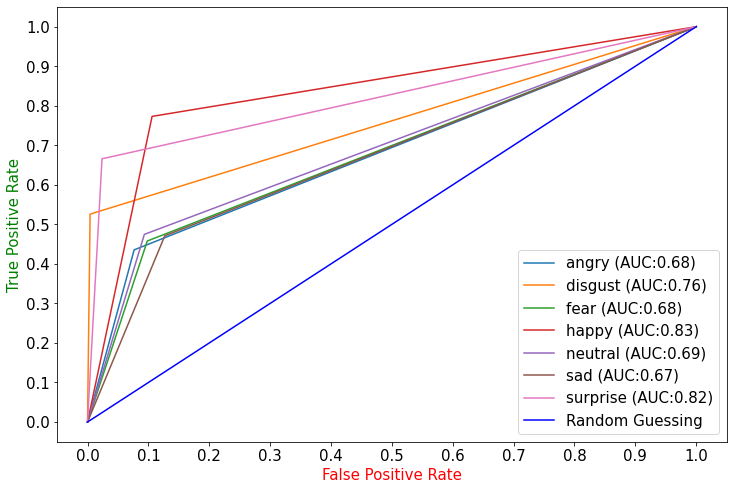

In [ ]:
plot_multiclass_roc_auc_score(model, X_test, Y_test)

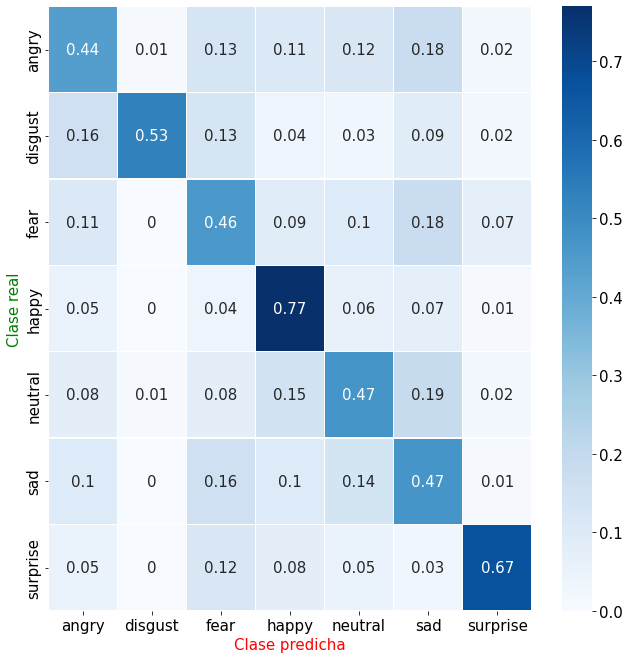

In [ ]:
print_confusion(model, X_test, Y_test)

In [ ]:
print(history.history)

{'loss': [1.8369905948638916, 1.3829305171966553, 1.055345058441162, 0.7803200483322144, 0.5371299982070923, 0.3661646842956543, 0.24006500840187073, 0.1729000061750412, 0.14289183914661407, 0.192312091588974, 0.1879432499408722, 0.14363998174667358, 0.08548753708600998, 0.07379603385925293, 0.07578607648611069, 0.11491500586271286, 0.16308161616325378, 0.11868766695261002, 0.0767187625169754], 'accuracy': [0.2878888249397278, 0.47741127014160156, 0.6154167652130127, 0.7248597741127014, 0.8190114498138428, 0.8800376057624817, 0.9251454472541809, 0.9490055441856384, 0.9553450345993042, 0.936849057674408, 0.9373018741607666, 0.9537427425384521, 0.9742937684059143, 0.977428674697876, 0.9749556183815002, 0.9609529972076416, 0.9449650049209595, 0.9619283080101013, 0.9765578508377075], 'recall_macro': [0.22482368350028992, 0.3951845169067383, 0.5316784977912903, 0.6480904221534729, 0.7694678902626038, 0.8566750288009644, 0.9088459014892578, 0.9350271821022034, 0.9484734535217285, 0.923317909

In [ ]:
history = {'loss': [1.8369905948638916, 1.3829305171966553, 1.055345058441162, 0.7803200483322144, 0.5371299982070923, 0.3661646842956543, 0.24006500840187073, 0.1729000061750412, 0.14289183914661407, 0.192312091588974, 0.1879432499408722, 0.14363998174667358, 0.08548753708600998, 0.07379603385925293, 0.07578607648611069, 0.11491500586271286, 0.16308161616325378, 0.11868766695261002, 0.0767187625169754], 'accuracy': [0.2878888249397278, 0.47741127014160156, 0.6154167652130127, 0.7248597741127014, 0.8190114498138428, 0.8800376057624817, 0.9251454472541809, 0.9490055441856384, 0.9553450345993042, 0.936849057674408, 0.9373018741607666, 0.9537427425384521, 0.9742937684059143, 0.977428674697876, 0.9749556183815002, 0.9609529972076416, 0.9449650049209595, 0.9619283080101013, 0.9765578508377075], 'recall_macro': [0.22482368350028992, 0.3951845169067383, 0.5316784977912903, 0.6480904221534729, 0.7694678902626038, 0.8566750288009644, 0.9088459014892578, 0.9350271821022034, 0.9484734535217285, 0.9233179092407227, 0.9305789470672607, 0.9453752636909485, 0.9695093035697937, 0.977182924747467, 0.9689422249794006, 0.9580540060997009, 0.9417874217033386, 0.9574306011199951, 0.9724895358085632], 'precision_macro': [0.23617185652256012, 0.3973437249660492, 0.5540279746055603, 0.694929838180542, 0.8034731149673462, 0.883034884929657, 0.9201402068138123, 0.9428026080131531, 0.9503892064094543, 0.9248678684234619, 0.9319071769714355, 0.947632372379303, 0.9706860184669495, 0.9756423234939575, 0.9639227390289307, 0.9553633332252502, 0.9409129023551941, 0.9556156992912292, 0.9735056161880493], 'f1_macro': [0.21362799406051636, 0.3883824348449707, 0.5305231213569641, 0.6552161574363708, 0.7773169875144958, 0.8633515238761902, 0.9097222685813904, 0.9370211958885193, 0.947482168674469, 0.9213097095489502, 0.9287870526313782, 0.9447371363639832, 0.9692580103874207, 0.9758076071739197, 0.9648829698562622, 0.9551883935928345, 0.9390702247619629, 0.9549704194068909, 0.9721226096153259], 'val_loss': [1.7320845127105713, 1.5507525205612183, 1.4662752151489258, 1.6031137704849243, 1.6585687398910522, 1.78000009059906, 1.7094157934188843, 1.8837487697601318, 1.9797543287277222, 1.9688286781311035, 2.044297218322754, 2.102358102798462, 2.158459424972534, 2.1988892555236816, 2.40431809425354, 2.25492262840271, 2.146278142929077, 2.117673397064209, 2.1944594383239746], 'val_accuracy': [0.3292003273963928, 0.41919755935668945, 0.4628030061721802, 0.4590415060520172, 0.49038729071617126, 0.5103092789649963, 0.5331568717956543, 0.5505712032318115, 0.5291167497634888, 0.5391473770141602, 0.5479242205619812, 0.5594873428344727, 0.5619949698448181, 0.5717470049858093, 0.5576762557029724, 0.5482028126716614, 0.5597659349441528, 0.5646419525146484, 0.5734187960624695], 'val_recall_macro': [0.24362064898014069, 0.3196265697479248, 0.37982338666915894, 0.3739452064037323, 0.42870816588401794, 0.46718668937683105, 0.5061694979667664, 0.5263124108314514, 0.5243942737579346, 0.5270677804946899, 0.5249653458595276, 0.5387725234031677, 0.5517204403877258, 0.5465631484985352, 0.5345892906188965, 0.5334905385971069, 0.533078670501709, 0.5554357171058655, 0.5505144000053406], 'val_precision_macro': [0.2599788308143616, 0.3607136011123657, 0.39226555824279785, 0.4144621193408966, 0.4797295928001404, 0.5027602314949036, 0.5407449007034302, 0.5628796219825745, 0.5604220628738403, 0.5484439730644226, 0.5457850098609924, 0.5724037885665894, 0.5712234973907471, 0.5621923208236694, 0.5711390376091003, 0.5700767636299133, 0.5551026463508606, 0.5630917549133301, 0.5820024013519287], 'val_f1_macro': [0.21525593101978302, 0.30074015259742737, 0.37120869755744934, 0.37228837609291077, 0.4282292127609253, 0.4678342640399933, 0.5100064873695374, 0.5328342914581299, 0.5277521014213562, 0.5260141491889954, 0.5272890329360962, 0.5420039892196655, 0.5544161796569824, 0.5428091287612915, 0.5388807654380798, 0.5365259051322937, 0.531789243221283, 0.5529401302337646, 0.5549261569976807]}

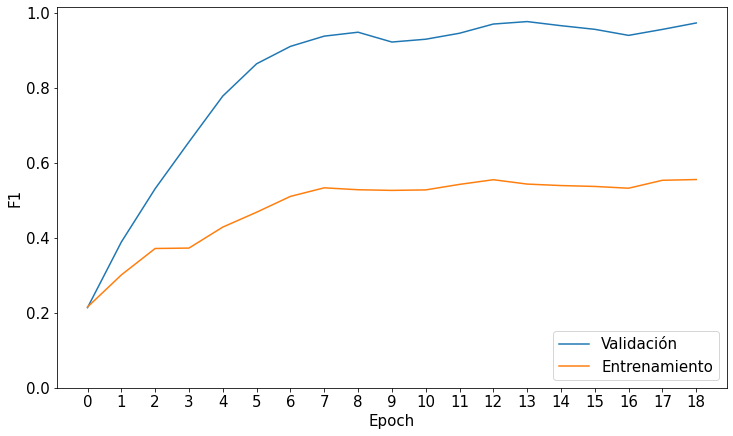

In [ ]:
print_metrics(history)